# Generative ML

In [1]:
%load_ext autoreload
%autoreload 2

**Setup**: Please follow the steps given below
- Download the MINST handwritten digits dataset from https://www.kaggle.com/datasets/hojjatk/mnist-dataset/data and extract its contents to a directory named "mnist"
- Please ensure that the cs771 directory has the helper modules plotData and utils
- Please ensure that the mnist directory, the cs771 directory and this notebook, all have the same parent directory

In [2]:
import numpy as np
from numpy import random as rand
from numpy import linalg as lin
import random
from cs771 import plotData as pd
from cs771 import utils
import struct
from array import array
from os.path import join
import matplotlib.pyplot as plt

MNIST dataset reader courtesy Hojjat Khodabakhsh
https://www.kaggle.com/code/hojjatk/read-mnist-dataset

In [3]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

In [4]:
#
# Set file paths based on added MNIST Datasets
#
input_path = 'mnist/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

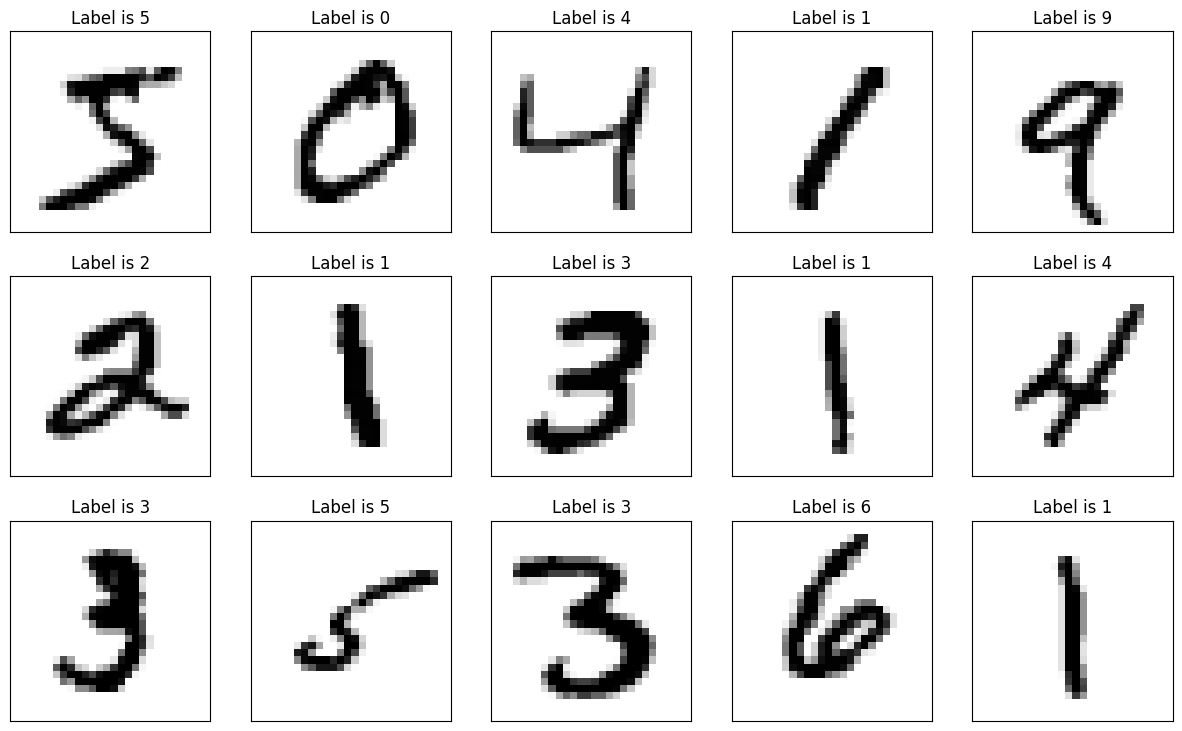

In [5]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
((XTrain, yTrain), (XTest, yTest)) = mnist_dataloader.load_data()
yTrain = np.array( yTrain )
yTest = np.array( yTest )

tmp = np.zeros( ( len( XTrain ), 28, 28 ) )
for i in range( len( XTrain )):
    tmp[ i, : ] = np.concatenate( XTrain[i] ).reshape( ( 28, 28 ) )
XTrain = tmp

tmp = np.zeros( ( len( XTest ), 28, 28 ) )
for i in range( len( XTest )):
    tmp[ i, : ] = np.concatenate( XTest[i] ).reshape( ( 28, 28 ) )
XTest = tmp

# How many training images do we have?
n = XTrain.shape[0]

# What is the shape of these images?
imShape = XTrain.shape[1:]

# Normalize data coordinates otherwise numbers in later calculations might explode
XTrain = XTrain/256

numRows = 3
numCols = 5

# Show the first 15 images in the dataset
fig, axs = pd.getFigList( numRows, numCols )
labels = [ "Label is %s" % yTrain[i] for i in range( numRows * numCols ) ]
pd.showImagesNoAxes( axs, XTrain[ :numRows*numCols ], numRows, numCols, labelList = labels )

**Creating a subdataset**: to make the generative learning problem simpler, let us create a smaller version of this dataset with just the images of digits 0 and 4 in the training set.

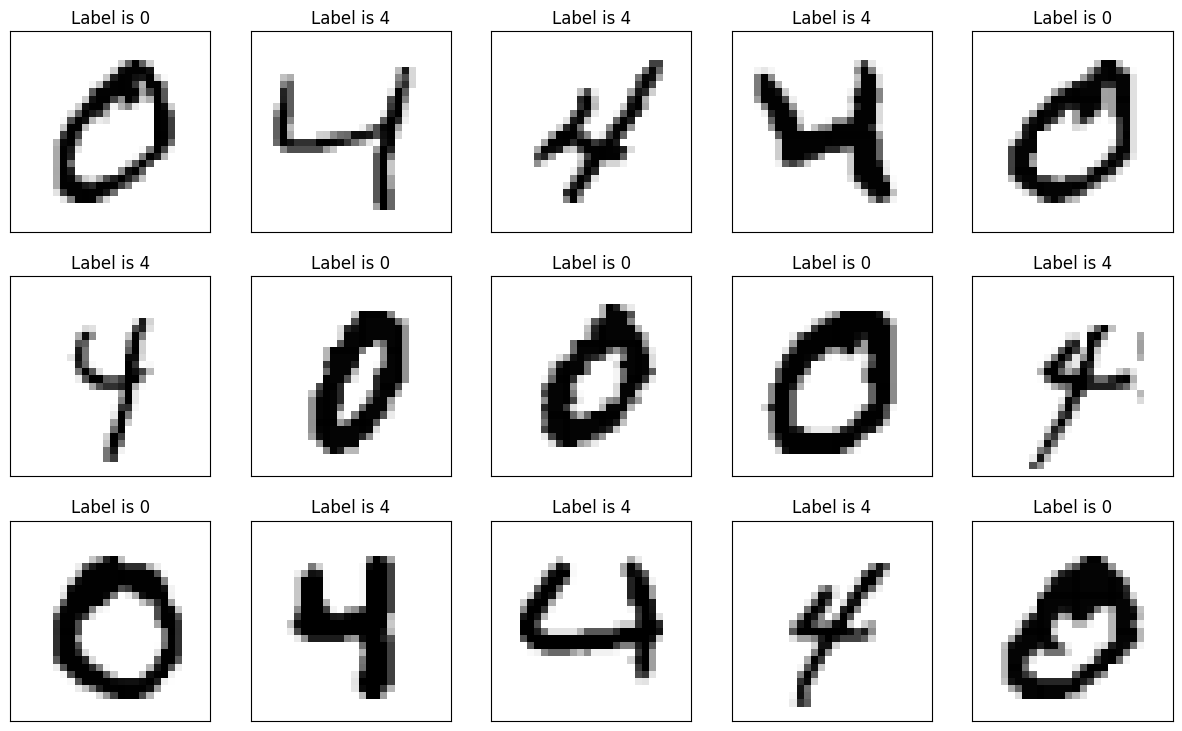

In [7]:
def getDataSubset( labels ):
    subset = np.isin( yTrain, labels )
    return (XTrain[subset][:][:], yTrain[subset])

labels = np.array( [0,4] )
(X,y) = getDataSubset( labels )

# Flatten images for sake of convenience even though it is time consuming and not essential at all
n = X.shape[0]
d = np.prod( X.shape[1:] )
X = X.reshape( n, d )

# Display the first few images of this subset dataset
fig2, axs2 = pd.getFigList( numRows, numCols )
labels = [ "Label is %s" % y[i] for i in range( numRows * numCols ) ]
pd.showImagesNoAxes( axs2, X[ :numRows*numCols ], numRows, numCols, resize = True, imShape = imShape, labelList = labels )

**Getting started**: let us start by fitting a single standard Gaussian as a generative model to our toy dataset of 0 and 4 images. We will see that this does not produce very good results at all. The mean image seems to be a ghostly superimposition of a 0 and a 4 which makes sense given the dataset contains 0s and 4s. The covariance structure is not getting learnt here at all (we are using the identity matrix as covaraiance) and the images generated out of this generative model turn out to be less than useful. Learning the structure of the covariance (and higher moments as well if possible) is vital in generative models.

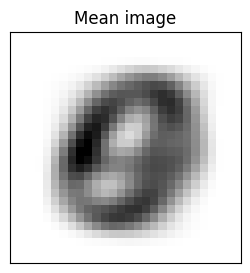

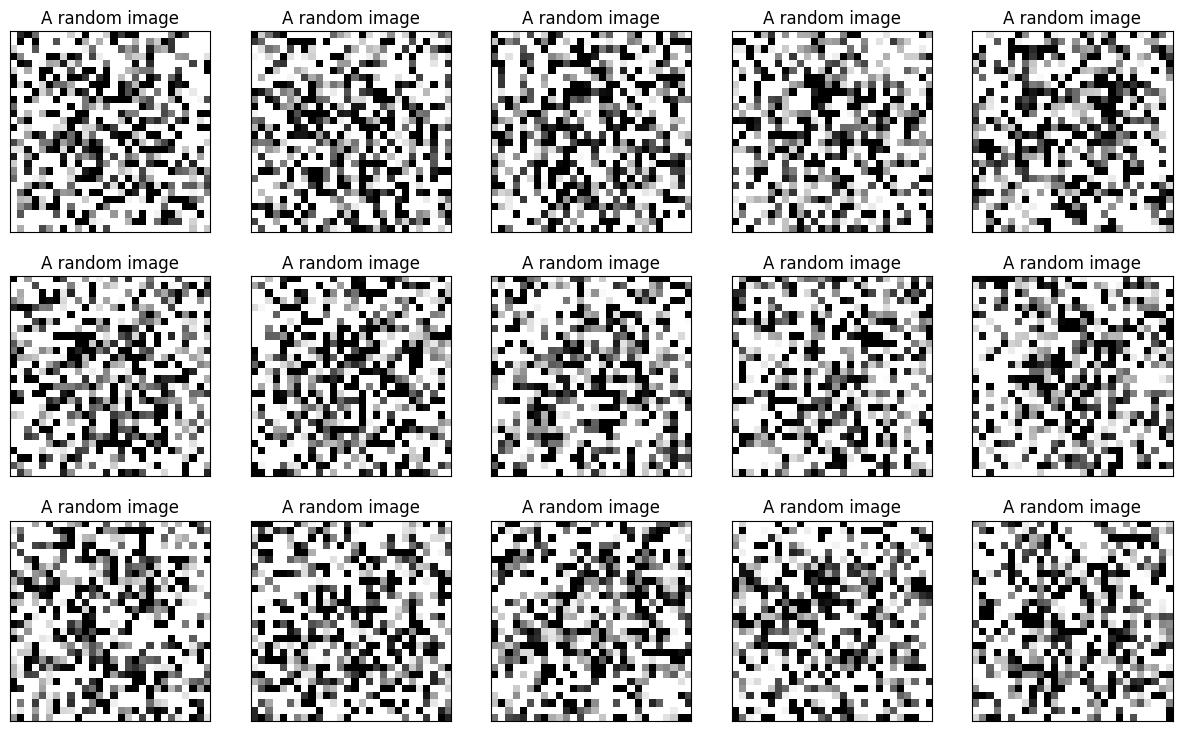

In [8]:
def fitSingleStandardGaussian( X ):
    return np.mean( X, axis = 0 )

def truncatePixels( X, low = 0, high = 1 ):
    X[X < low] = low
    X[X > high] = high
    return X

# Fit a standard Gaussian to the 0,4 dataset using an MLE
mu = fitSingleStandardGaussian( X )
fig3, axs3 = pd.getFigList( 1, 1 )
labels = [ "Mean image" ]
pd.showImagesNoAxes( axs3, mu[ np.newaxis, : ], 1, 1, resize = True, imShape = imShape, labelList = labels )

# Display a few samples taken from this distribution -- we will find these to be extremely noisy
fig4, axs4 = pd.getFigList( numRows, numCols )
labels = [ "A random image" for i in range( numRows * numCols ) ]
randSamples = rand.multivariate_normal( mu, np.identity(d), size = numRows * numCols, check_valid = "raise" )
randSamples = truncatePixels(randSamples)
pd.showImagesNoAxes( axs4, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

**The limits of a single Gaussian**: Let us learn a proper Gaussian now with both the mean and covariance getting learnt. The mean is the same as before but the crucial difference is that the covariance is getting learnt now. Notice the significant improvement in the quality of the images generated from this generative model. Although still far from satisfactory, the images at least show some semblance of 0 and 4 shapes haphazardly placed on top of each other. Learning the covariance structure properly itself caused this huge improvement.

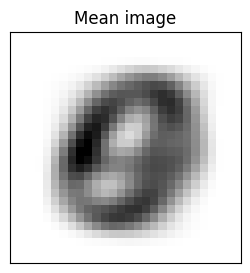

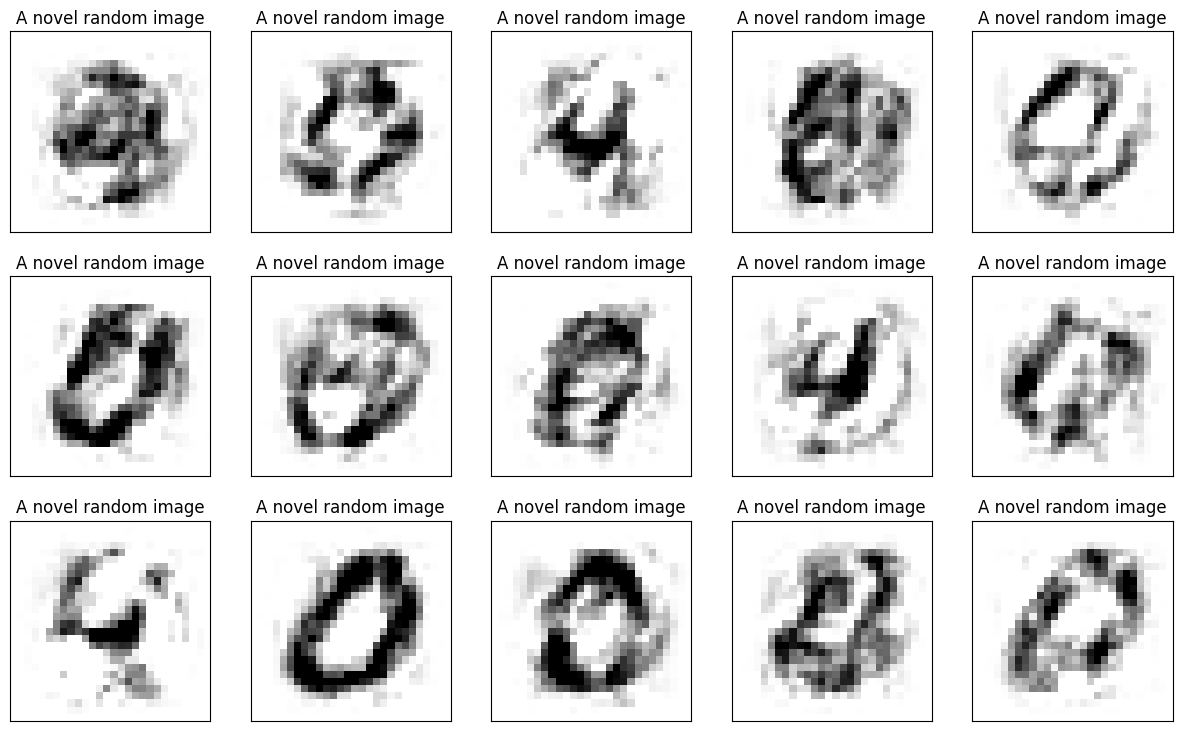

In [9]:
def fitSingleGaussian( X ):
    n = X.shape[0]
    d = np.prod( X.shape[1:] )
    X = X.reshape( n, d )
    mu = np.mean( X, axis = 0 )
    Xcent = X - mu
    cov = 1/n*(Xcent.T).dot(Xcent)
    return (mu, cov)

# Fit a general Gaussian this time to the same dataset
(mu, cov) = fitSingleGaussian( X )

fig5, axs5 = pd.getFigList( 1, 1 )
labels = [ "Mean image" ]
pd.showImagesNoAxes( axs5, mu[ np.newaxis, : ], 1, 1, resize = True, imShape = imShape, labelList = labels )

# The quality of samples is a bit better due to use of a general covariance matrix but not much better
fig6, axs6 = pd.getFigList( numRows, numCols )
labels = [ "A novel random image" for i in range( numRows * numCols ) ]
randSamples = rand.multivariate_normal( mu, cov, size = numRows * numCols, check_valid = "raise" )
randSamples = truncatePixels( randSamples )
pd.showImagesNoAxes( axs6, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

**A mixture of Gaussians**: since we know that our toy dataset contains a bunch of 0s and 4s whose appearances differ significantly, it is not surprising that a single Gaussian was unable to capture the diversity in the dataset. Let us now fit a mixture of Gaussians to this dataset. We need at least 2 components in this mixture (i.e. at least 2 Gaussians) but it is better to use slightly more e.g. 4 or more since even within a digit, there may be variations in writing style e.g. the digit 4 written upright vs written slanted.

Note that we are assuming that we do not have the labels of the imags in our training set i.e. we do not know which images are labeled 0 and which are labeled 4. This means that we would have to model this as a latent variable and use the EM algorithm to fit the mixture of Gaussians. Even if we had known the labels of the images, we would have still required the EM algorithm if, for example, we want to model the 4s using 3 components to account for variations of style etc. Since the images surely do not come labeled whether they are upright or slanted, a latent variable will be required to model this information.

**Number of Components**: Notice the significantly better samples generated by this mixture model. The samples are very realistic, diverse, yet are novel, i.e. these were never seen in training set. The quality of the samples would generally go up as the number of mixture components goes up, but if the number of components gets very large, then the method would start suffering since not only would it become slow, the number of data points per component would also fall and each component would get estimated not very well. The number of components in the mixture is a hyperparameter that needs to be tuned carefully. Too small and diversity would not be captured, too large and estimation and speed would suffer.

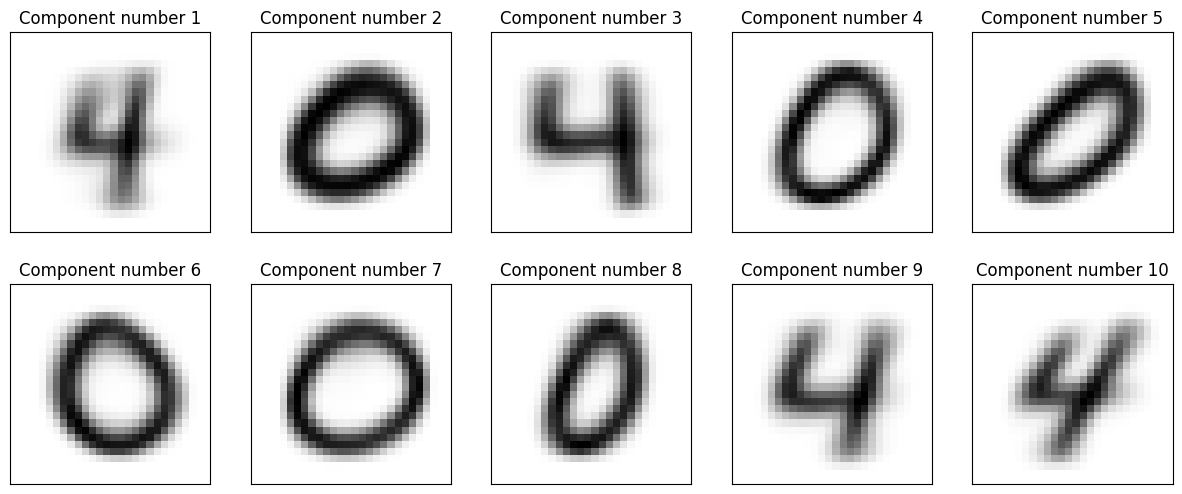

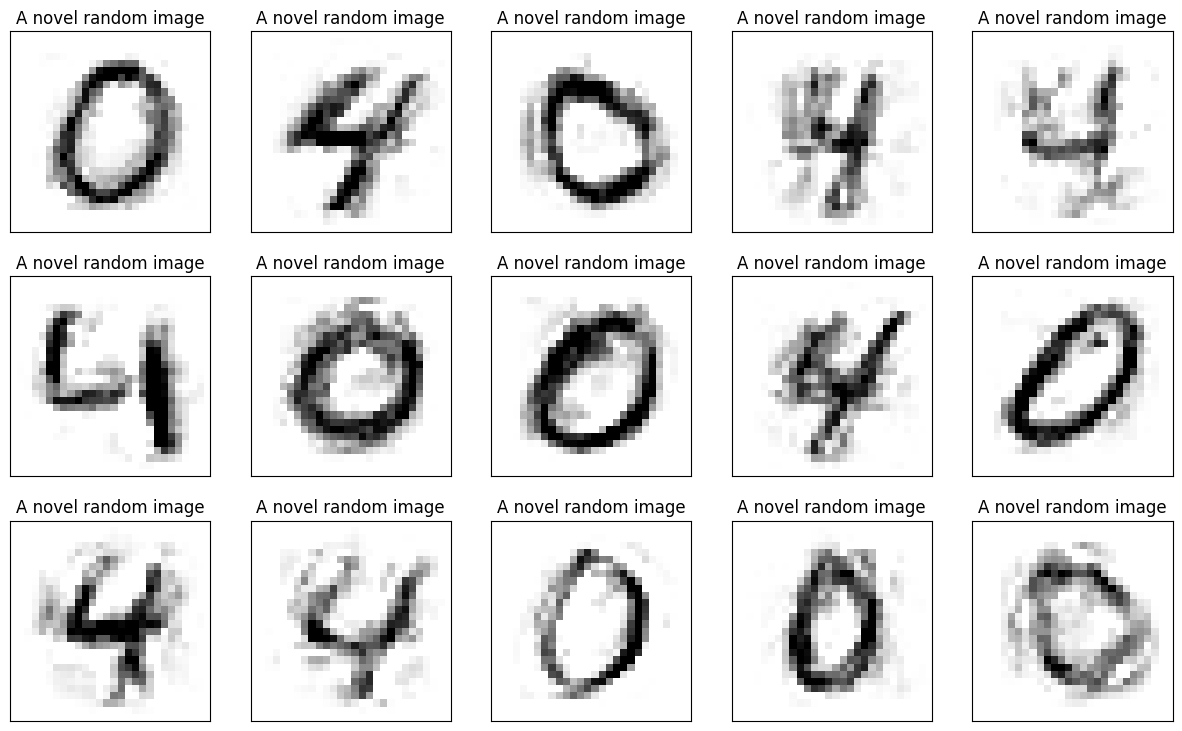

In [10]:
# Perform the k-means++ initialization
def doKMPPInitGreedy( X, C ):
    init = np.zeros( (C, X.shape[1]) )
    n = X.shape[0]
    # Choose a random data point and make it a centroid
    i = random.randint( 0, n-1 )
    init[0,:] = X[i,:]
    for t in range( 1, C ):
        # For all data points, find the squared Euclidean distance to the closest centroid
        # Python is funny: init[0,:] generates a vector but init[0:1,:] generates a matrix with one row :)
        dist = np.min( utils.getAllPairsDistances( X, init[0:t,:] ), axis = 1 )
        i = np.argmax( dist )
        init[t,:] = X[i,:]
    return init

def getSigmaInit( C, d ):
    iden = np.identity( d )
    init = np.zeros( (C, d, d) )
    for i in range( C ):
        init[i] = iden
    return init

# Obtain probability of data point x^i belonging to component N(\mu^c, S^c)
# The proper way of computing this is 1/\sqrt((2\pi)^d*|S^c|)*exp( - (x^i - \mu^c)'(S^c)^{-1}(x^i - \mu^c))
# However, this can be very expensive due to all the inverses involved
# Cheaper shortcut: approximate S^c by the identity matrix I_d
def doEStep( X, muVals, SigmaVals ):
    qVals = np.exp( -utils.getAllPairsDistances( X, muVals ) / 2 )        
    rowSum = qVals.sum( axis = 1 )
    qVals = qVals / rowSum[:, np.newaxis]
    return qVals

# Update the models by optimizing the Q function given by the E Step
# Ideally, both means and covariances for all components should be updated
# The solution to the weighted MLE for the covariance matrix update can be shown to be
# S^c = 1/Q_c * \sum_{i=1}^n q^i_c (x^i - \mu^c)(x^i - \mu^c)^T where Q_c = \sum_{i=1}^n q^i_c
# Cheaper shortcut: do not update covariance matrix at every M step (update only means every time)
# Update covariance only at the end (we are anyway not using SigmaVals to compute the E step)
def doMStep( X, qVals, C, prevMuVals, prevSigmaVals ):
    d = X.shape[1]
    muVals = np.zeros( (C, d) )
    SigmaVals = np.zeros( (C, d, d) )
    
    # Process every component
    for c in range( C ):
        # Get hold of the weights different data points have given to this component
        q = qVals[:, c]
        amountData = sum(q)
        # If there is enough data for this component, do weighted MLE estimation
        if amountData > 1:
            muVals[c] = (X.T).dot( q )/amountData
        # If some cluster is almost empty, return the old value of its centroid
        else:
            muVals[c] = prevMuVals[c]
    return (muVals, SigmaVals)

# Execute the EM algorithm for jointly learning a mixture of general (not standard) Gaussians
def doEMGMM( X, C, initMu, initSigma, niter ):
    muVals = initMu
    SigmaVals = initSigma
    # Perform the EM algorithm for niter steps
    for t in range( niter ):
        qVals = doEStep( X, muVals, SigmaVals )
        (muVals, SigmaVals) = doMStep( X, qVals, C, muVals, SigmaVals )
    # Cheaper shortcut we employed -- doing costly S^c updates only once at the end
    for c in range( C ):
        q = qVals[:, c]
        amountData = sum(q)
        if amountData > 1:
            Xcent = X - muVals[c]
            wXCent = (Xcent.T * q).T
            SigmaVals[c] = 1 / amountData * (wXCent.T).dot( Xcent )
    return (muVals, SigmaVals, qVals)

# Number of components in the Gaussian mixture model (GMM)
C = 10
niter = 5

initMu = doKMPPInitGreedy( X, C )
initSigma = getSigmaInit( C, X.shape[1] )
(muVals, SigmaVals, qVals) = doEMGMM( X, C, initMu, initSigma, niter )
        
numRows = 2
numCols = C//2

# Visualize the means/modes of the various components the EM algorithm returned
# Notice how the various components do not just capture the different digits but also
# different ways/styles of writing each digit e.g. slanted 0 vs fat round 0 etc
fig7, axs7 = pd.getFigList( numRows, numCols )
labels = [ "Component number %s" % (i+1) for i in range( numRows * numCols ) ]
pd.showImagesNoAxes( axs7, muVals, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

numRows = 3
numCols = 5

fig8, axs8 = pd.getFigList( numRows, numCols )
labels = [ "A novel random image" for i in range( numRows * numCols ) ]
randSamples = np.zeros( (numRows * numCols, d) )
for i in range( numRows * numCols ):
    # Choose a random component of the GMM from which to sample
    # It should be noted here that we have not used the label information in the data at all
    # All these results are being achieved in a completely "unsupervised" setting
    # Also note that all of these are novel images -- that never appeared in the training set
    # Notice the significantly improved quality of the novel images compared to previous attempts
    idx = random.randint( 0, C - 1 )
    randSamples[i] = rand.multivariate_normal( muVals[idx], SigmaVals[idx], check_valid = "raise" )

randSamples = truncatePixels( randSamples )
pd.showImagesNoAxes( axs8, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

**The importance of modelling covariances**: the covariance of a vector random variable tells us how two of its components vary together. For example, does one component always take a low value when the other one takes a high value, or do both take high and low values together, or are the components uncorrelated? We conduct a toy experiment to explicitly see this happening.

**Another Toy Dataset**: let us create another toy dataset of upright and inverted 7s. Notice that an upight 7 means that there are black pixels at the top-left, top-right, and bottom-right regions of the image. An inverted 7, on the other hand means that there are black pixels in the top-left, bottom-left, and bottom-right regions of the image.

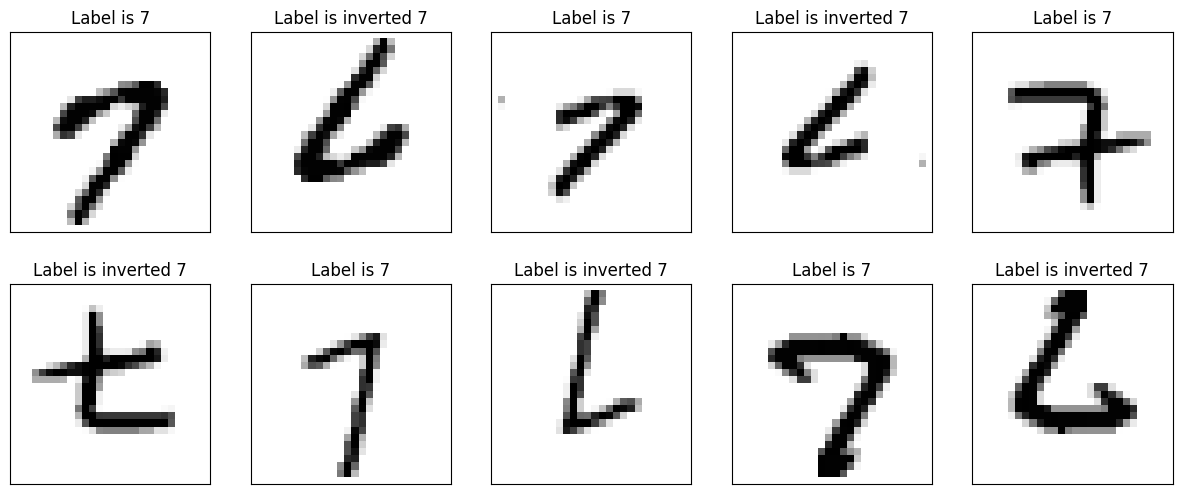

In [11]:
labels = np.array( [7] )
(X,y) = getDataSubset( labels )
Xinv = X[:,::-1,::-1]
n = X.shape[0]
d = np.prod( X.shape[1:] )
X = X.reshape( n, d )
Xinv = Xinv.reshape( n, d )

Xcomb = np.zeros( (2 * n, d) )
Xcomb[::2] = X
Xcomb[1::2] = Xinv

n = 2 * n

numRows = 2
numCols = 5

fig9, axs9 = pd.getFigList( numRows, numCols )
labels = [ "" for i in range( numRows * numCols ) ]
labels1 = [ "Label is %s" % y[i] for i in range( (numRows * numCols) // 2 ) ]
labels2 = [ "Label is inverted %s" % y[i] for i in range( (numRows * numCols) // 2 ) ]
labels[::2] = labels1
labels[1::2] = labels2

pd.showImagesNoAxes( axs9, Xcomb[:numRows*numCols], numRows, numCols, resize = True, imShape = imShape, labelList = labels )

Suppose we want to learn a single Gaussian (not a mixture) as a generative model to fit this dataset. Fitting a spherical Gaussian i.e. whose covariance matrix is a multiple of the identity matrix gives very poor samples since such a distribution is incapable of storing the fact that in this toy dataset, if there are black pixels in the top-right region, then the bottom-left region is largely vacant (since that would be an upright 7) and if there are black pixels in the bottom-left region, then the top-right region is largely vacant (since that would be an inverted 7). Only covariance among different pixels can allow a distribution to store such information about correlated behavior among pixels.

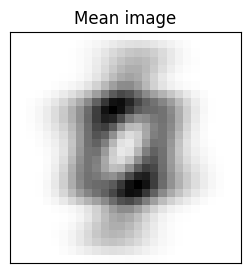

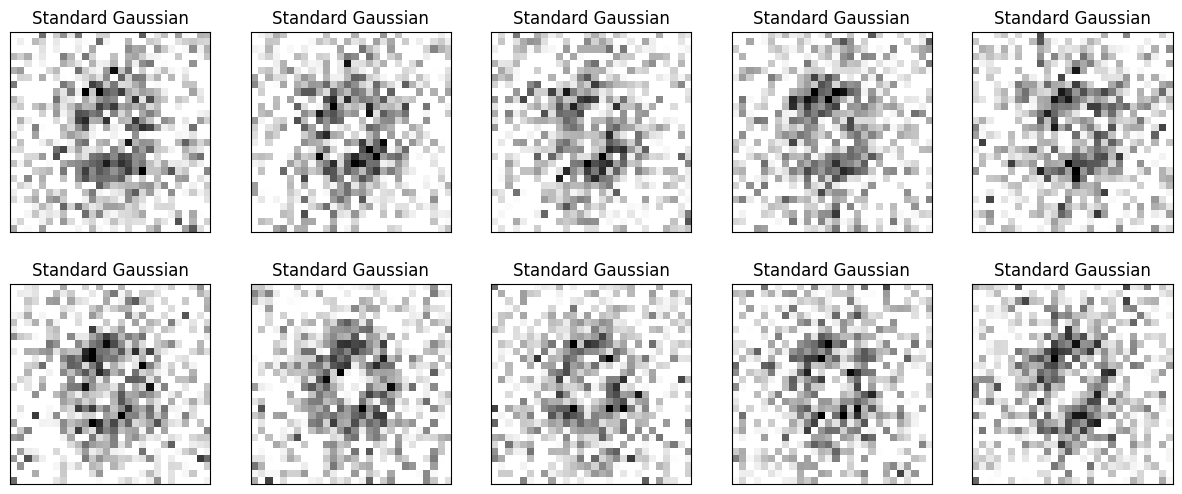

In [12]:
mu = fitSingleStandardGaussian( Xcomb )
sigmaSq = np.square( lin.norm( Xcomb - mu, 'fro' ) ) / (n * d)

fig10, axs10 = pd.getFigList( 1, 1 )
labels = [ "Mean image" ]
pd.showImagesNoAxes( axs10, mu[ np.newaxis, : ], 1, 1, resize = True, imShape = imShape, labelList = labels )

fig11, axs11 = pd.getFigList( numRows, numCols )
labels = [ "Standard Gaussian" for i in range( numRows * numCols ) ]
randSamples = rand.multivariate_normal( mu, sigmaSq*np.identity( d ), size = numRows * numCols, check_valid = "raise" )
randSamples = truncatePixels( randSamples )
pd.showImagesNoAxes( axs11, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

Using a proper Gaussian with a general covariance allows even a single Gaussian to capture the fact that there exist upright and inverted 7s in this dataset and give much better samples. Note that most of the samples are either clearly upright 7s or else clearly inverted 7s i.e. the distribution has learnt this fact about pixels in the top-right and bottom-left corner being anti-correlated in this dataset. Note that we did not need a mixture of 2 or more Gaussians to capture this behavior! Of course, learning a mixture of Gaussians would indeed give better results but be more expensive in terms of training time and model size too.

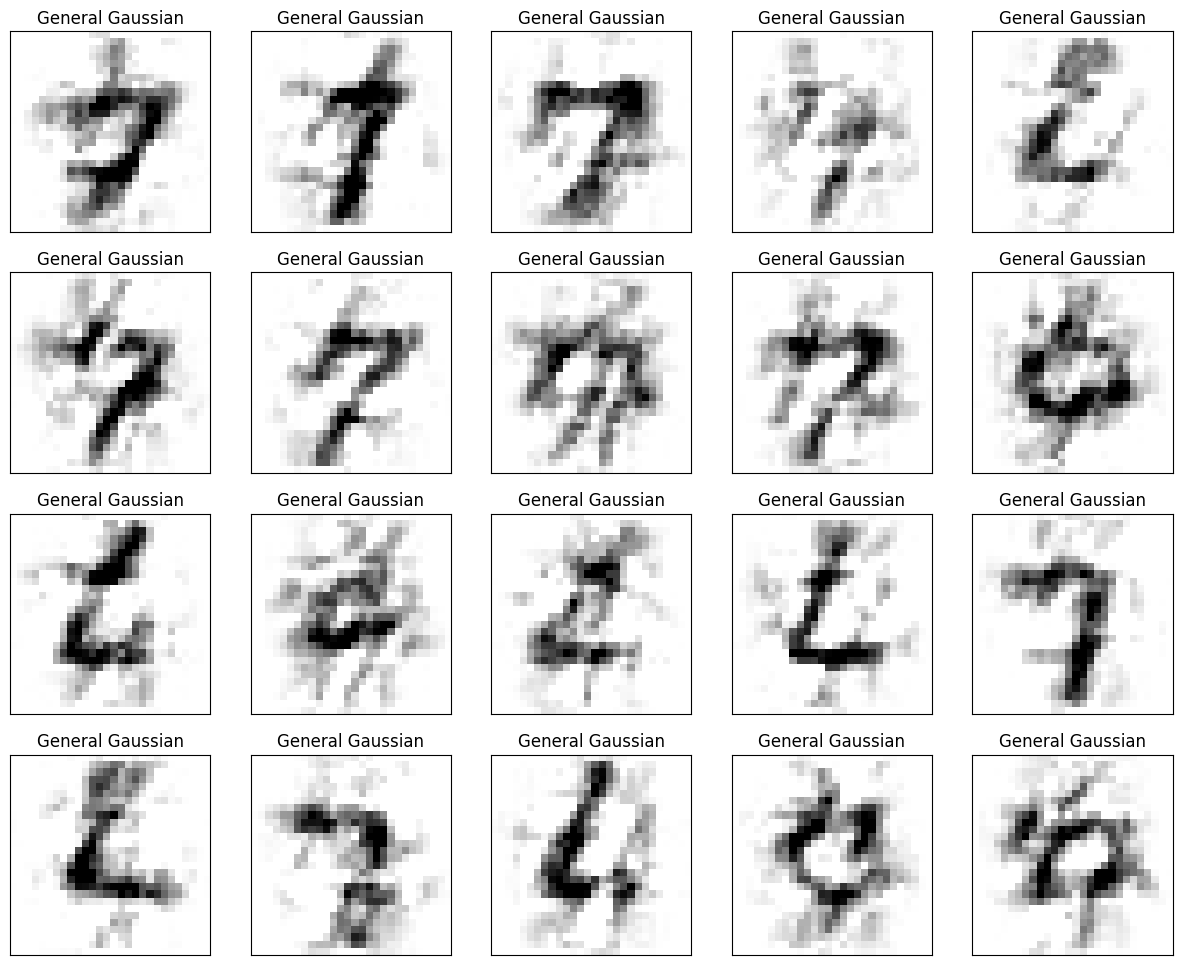

In [13]:
(mu, cov) = fitSingleGaussian( Xcomb )

numRows = 4
numCols = 5

fig12, axs12 = pd.getFigList( numRows, numCols )
labels = [ "General Gaussian" for i in range( numRows * numCols ) ]
randSamples = rand.multivariate_normal( mu, cov, size = numRows * numCols, check_valid = "raise" )
randSamples = truncatePixels( randSamples )
pd.showImagesNoAxes( axs12, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

**Classification using a Generative Model**: Generative models can not only generate new examples, they can also be used to classify data points as well. In the following, we take the full MNIST dataset (i.e. not just 0s or 4s or 7s) and learn a single Gaussian per class. Note that now we are indeed using the labels of the images i.e. we are no longer doing EM. We are simply learning the mean and covariance for 10 Gaussians, one corresponding to each of the classes {0, 1, ..., 9} in the dataset. This method gets an 85.73% prediction accuracy on the test dataset. This is decent although not very impressive. Using kernel SVMs, it is possible to get around 95% prediction accuracy and deep convolutional networks can drive this up to 99.9% and above. However, notice that this is an extremely simple generative model and yet it offers some decent prediction accuracy.

Prediction Accuracy:  0.8573


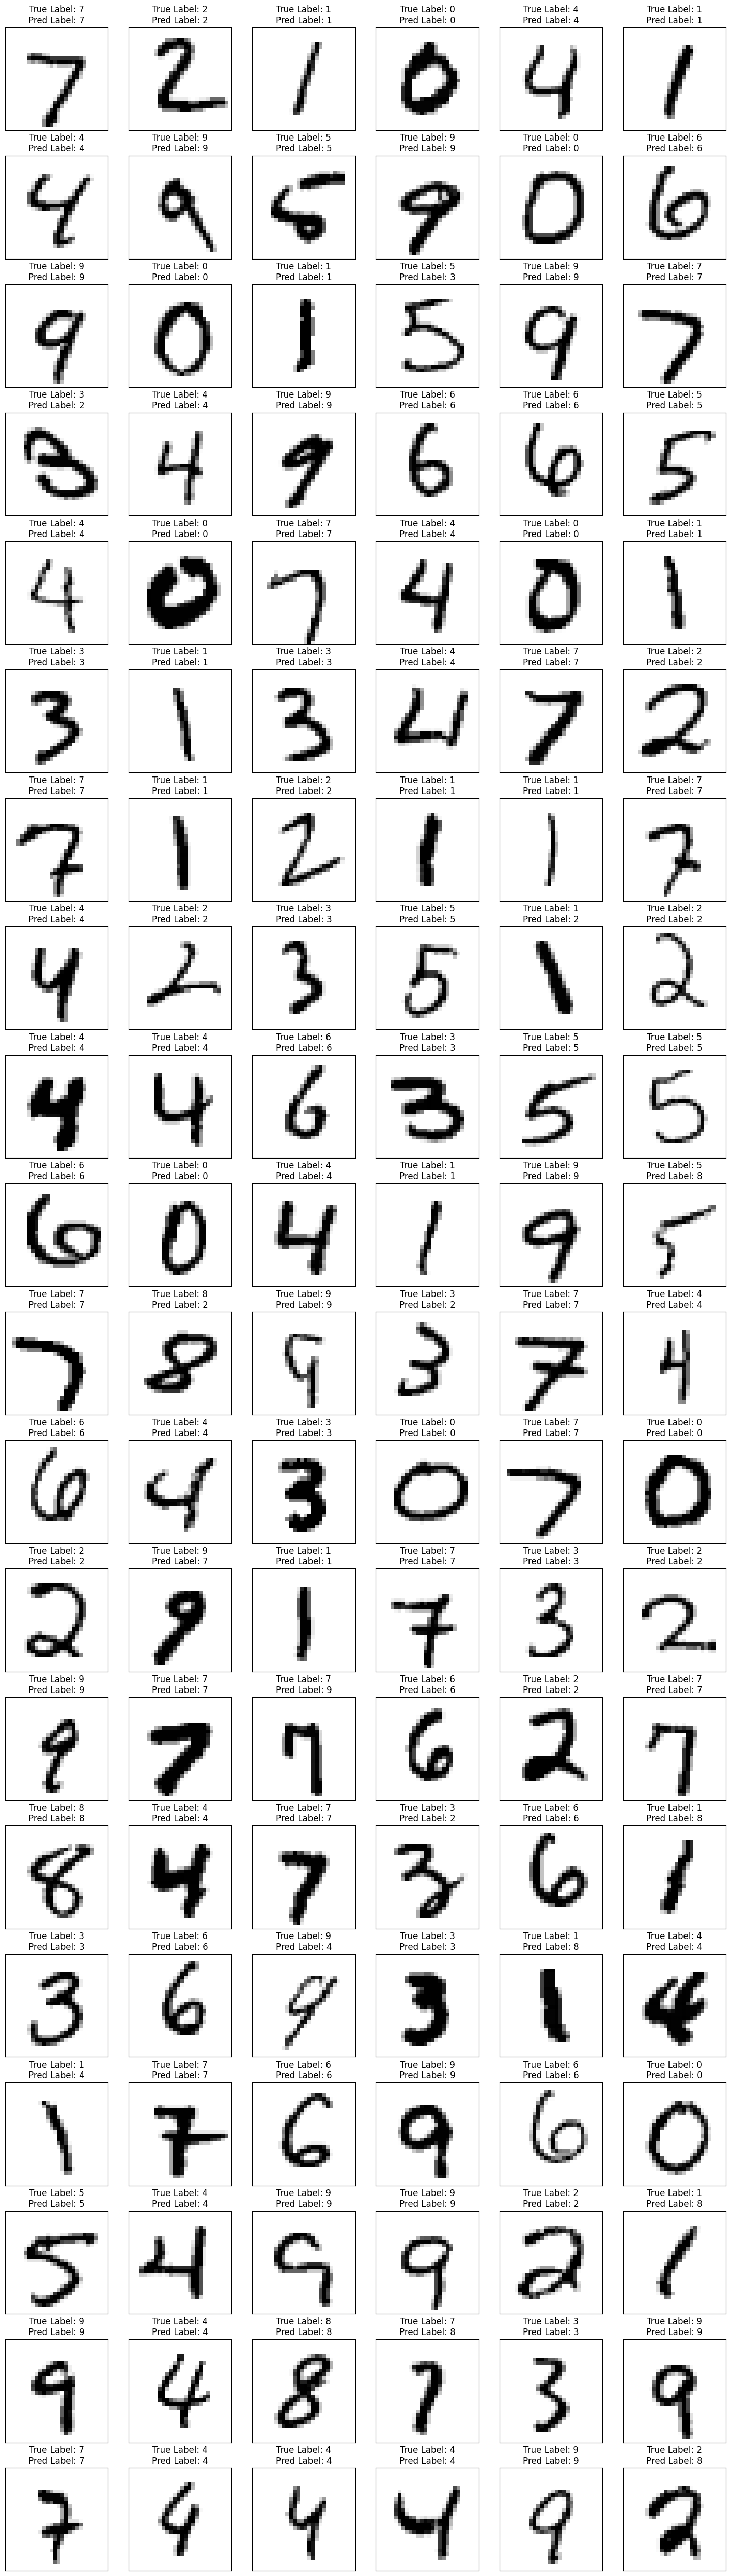

In [7]:
# Learn a single (general) Gaussian per class
def learnClassConditionalDist( X, y ):
    (labels, labelCounts) = np.unique( y, return_counts = True )
    C = labels.size
    (n, d) = X.shape
    muVals = np.zeros( (C, d) )
    SigmaVals = np.zeros( (C, d, d) )
    for c in range( C ):
        XThisLabel = X[y == c]
        # MLE for mean is simply the empirical mean (aka sample mean) of feature vectors of this class
        muVals[c] = np.mean( XThisLabel, axis = 0 )
        XCent = XThisLabel - muVals[c]
        # MLE for covariance matrix is simply the empirical/sample covariance matrix of this class
        SigmaVals[c] = 1/labelCounts[c]*(XCent.T).dot( XCent )
    return (C, list( zip( muVals, SigmaVals, np.arange( C ), labelCounts/n ) ))

# Stretch out the 28 x 28 image into a 784 dimensional vector
def flattenTensor( X ):
    n = X.shape[0]
    d = np.prod( X.shape[1:] )
    return X.reshape( n, d )

def predictClassScores( X, mu, Sigma, p, mask = [] ):
    # If no mask was provided, then we need to consider all coordinates of the feature vector
    if len(mask) == 0:
        mask = np.ones( (X.shape[1],), dtype=bool )
    
    XCent = X[:,mask] - mu[mask]
    # The covariance matrix will mostly be non-invertible in this case
    # This is because some pixels are always white in every image i.e. zero variance
    # The Moore-Penrose "pseudoinverse" is used in such situations
    SInv = lin.pinv( Sigma[mask,:][:,mask] )
    # numpy has a helpful routine that directly calculates the logdet of a matrix
    # More numerically stable in several situations -- no exploding outputs
    (sign, logdet) = lin.slogdet( Sigma[mask,:][:,mask] )
    # sign = 0 is the routines way of telling us that the determinant was zero
    # The determinant of a covariance matrix should always be non-negative
    if sign <= 0:
        SLogDet = 0
    else:
        SLogDet = logdet
    # This term gives us (ignoring additive constants) ln P[x | y, \theta]
    term1 = 0.5 * (-SLogDet - np.sum( np.multiply( np.dot(XCent, SInv), XCent), axis = 1 ))
    # This term gives us ln P[y | \theta]
    term2 = np.log( p )
    return term1 + term2

def predictGen( X, model, C, mask = [] ):
    classScores = np.zeros( (X.shape[0], C) )
    for mu, Sigma, c, p in model:
        classScores[:,c] = predictClassScores( X, mu, Sigma, p, mask )
    return np.argmax( classScores, axis = 1 )

((XTrain, yTrain), (XTest, yTest)) = mnist_dataloader.load_data()
yTrain = np.array( yTrain )
yTest = np.array( yTest )

tmp = np.zeros( ( len( XTrain ), 28, 28 ) )
for i in range( len( XTrain )):
    tmp[ i, : ] = np.concatenate( XTrain[i] ).reshape( ( 28, 28 ) )
XTrain = tmp

tmp = np.zeros( ( len( XTest ), 28, 28 ) )
for i in range( len( XTest )):
    tmp[ i, : ] = np.concatenate( XTest[i] ).reshape( ( 28, 28 ) )
XTest = tmp

# Normalize data coordinates otherwise numbers in later calculations explode
# Also, flatten images for sake of convenience
imShape = XTrain.shape[1:]
XTrainFlat = flattenTensor( XTrain/256 )
XTestFlat = flattenTensor( XTest/256 )

(C, model) = learnClassConditionalDist( XTrainFlat, yTrain )
yPred = predictGen( XTestFlat, model, C )

print( "Prediction Accuracy: ", sum(yPred == yTest)/yTest.size )

numRows = 20
numCols = 6

fig13, axs13 = pd.getFigList( numRows, numCols, sizey = 3.2 )
labels = ["True Label: %s\nPred Label: %s" % (yTest[i], yPred[i]) for i in range( numRows * numCols )]
pd.showImagesNoAxes( axs13, XTestFlat[:numRows*numCols], numRows, numCols, resize = True, imShape = imShape, labelList = labels )

**Classification in the presence of missing features**: a very nice property of generative models is that they allow us to perform classification on test points even those test points have missing features. Generative models can also function even if training data has missing features but those algorithms are more involved since they require the use of latent variables and some version of the EM algorithm to be executed.

Below we use the generative mode we trained above, to classify test images for whom a whole bunch of pixels have been removed or _censored_. We see that classification accuracy drops as more and more pixels are wiped out which is expected. What is interesting is that if we wipe out all pixels (we can do this by setting X[:, :, :] = 0 in the method censorImages() below), we get a prediction accuracy of around 11%. The reason for this is two-fold.
1. We will see that when all pixels are wiped out, the method always predicts the label of the image as 1. Since 1s constitute around 11% of the dataset, this explains the 11% accuracy since the method is technically correct on those images.
1. The reason why the method predicts 1 as the default label for a totally blank image has to do with the fact that the the label 1 is among the most popular in the dataset and so the class has high prior probability. Moreover, images of the digit 1 contain the most blank/white space so even in terms of likelihood, the label 1 wins when the image is completely blank.
1. The above two factors imply that the label 1 wins for a blank image.

In the following, we remove around 21% of the central portion of the test images. This causes prediction accuracy to drop to 78.57. However, given their generative capabilities, generative models are not just able to classify test data points with missing features, they are able to _impute_ or fill-in those missing features with reasonable values as well. Examples of such reconstructions are given below. Note that the reconstructions are decent although a bit blurry. This is all the more impressive when we look at the censored images which, to the human eye, seem to convey little information about the true image since the central portions are crucial in the images and those are exactly the pixels that got censored. Also notice that some of the misclassification are reasonable e.g. misclassifying a 9 as a 7 etc.

Prediction Accuracy on Censored Images:  0.7857


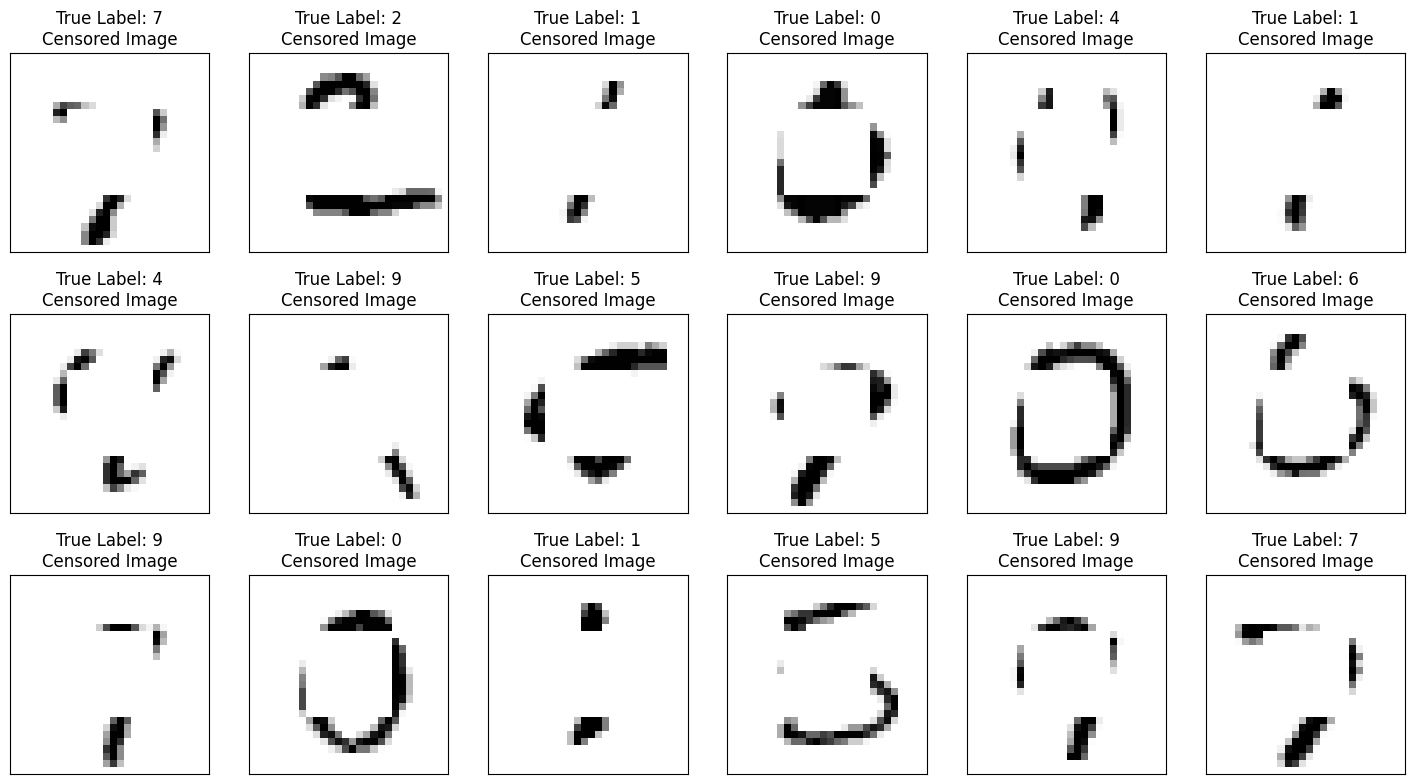

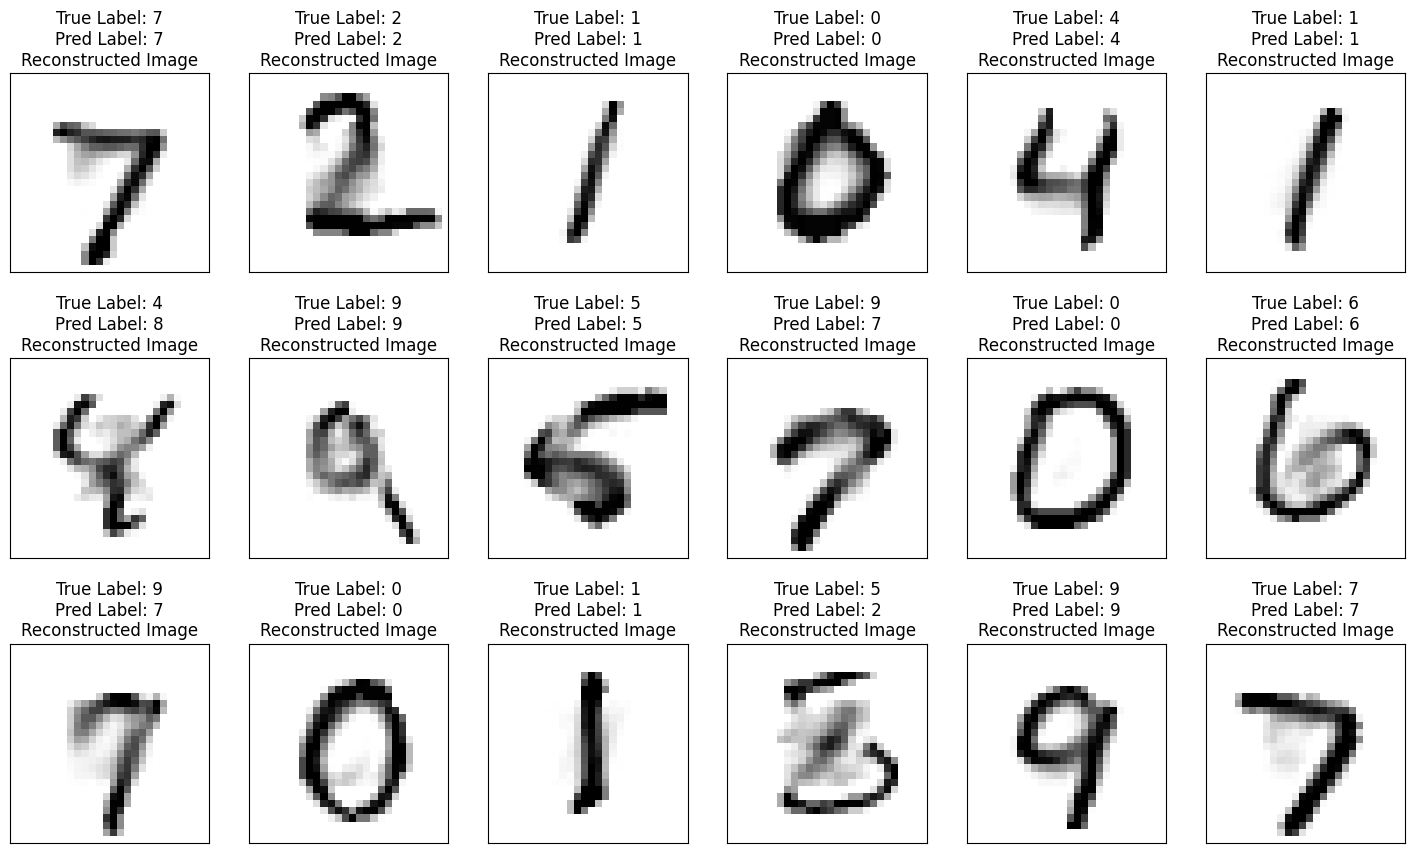

In [7]:
# You may try more aggressive censoring e.g. X[:, 5:20, 5:20] = 0 which wipes out around 28% of the pixels
# Accuracy will fall as we wipe out more and more pixels
def censorImages( X ):
    # Wipe out 21% of the pixels from the central part of the image
    X[:, 8:20, 8:20] = 0
    return X

# Make sure that reconstructed image does not have any negative-valued pixels
def truncatePixels( X, low = 0, high = 1 ):
    X[X < low] = low
    X[X > high] = high
    return X

# Reconstruct the image using the Gaussian conditionals
def reconstructImages( X, yPred, model, mask ):
    XRecon = np.zeros( X.shape )
    # Pixels observed are used as is in the reconstruction
    XRecon[:, mask] = X[:, mask]
    for i in range( X.shape[0] ):
        ( mu, Sigma, c, p ) = model[yPred[i]]
        recon = mu[~mask] + Sigma[~mask,:][:,mask].dot( lin.pinv( Sigma[mask,:][:,mask] ).dot( (XRecon[i,mask] - mu[mask]) ) )
        XRecon[i, ~mask] = recon
    return truncatePixels( XRecon )

((XTrain, yTrain), (XTest, yTest)) = mnist_dataloader.load_data()
yTrain = np.array( yTrain )
yTest = np.array( yTest )

tmp = np.zeros( ( len( XTrain ), 28, 28 ) )
for i in range( len( XTrain )):
    tmp[ i, : ] = np.concatenate( XTrain[i] ).reshape( ( 28, 28 ) )
XTrain = tmp

tmp = np.zeros( ( len( XTest ), 28, 28 ) )
for i in range( len( XTest )):
    tmp[ i, : ] = np.concatenate( XTest[i] ).reshape( ( 28, 28 ) )
XTest = tmp

XTestCensorFlat = flattenTensor( censorImages( XTest ) / 256 )
mask = flattenTensor( censorImages( np.ones( imShape )[np.newaxis, :] ) )[0] == 1

yPred = predictGen( XTestCensorFlat, model, C, mask )

print( "Prediction Accuracy on Censored Images: ", sum(yPred == yTest)/yTest.size )

numRows = 3
numCols = 6

XTestReconFlat = reconstructImages( XTestCensorFlat[:numRows*numCols], yPred[:numRows*numCols], model, mask )

fig14, axs14 = pd.getFigList( numRows, numCols, sizey = 3.2 )
labels = ["True Label: %s\nCensored Image" % yTest[i] for i in range( numRows * numCols )]
pd.showImagesNoAxes( axs14, XTestCensorFlat[:numRows*numCols], numRows, numCols, resize = True, imShape = imShape, labelList = labels )

fig15, axs15 = pd.getFigList( numRows, numCols, sizey = 3.5 )
labels = ["True Label: %s\nPred Label: %s\nReconstructed Image" % (yTest[i], yPred[i]) for i in range( numRows * numCols )]
pd.showImagesNoAxes( axs15, XTestReconFlat[:numRows*numCols], numRows, numCols, resize = True, imShape = imShape, labelList = labels )

In [ ]:
# Import necessary libraries
import numpy as np
from numpy import random as rand
from numpy import linalg as lin
import random
from cs771 import plotData as pd
from cs771 import utils
import struct
from array import array
from os.path import join
import matplotlib.pyplot as plt
import time

# --- 1. Data Loading (Unchanged from your prompt) ---
# input_path = 'mnist/'
# training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
# training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
# test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
# test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
# ((XTrain, yTrain), (XTest, yTest)) = mnist_dataloader.load_data()
# yTrain = np.array(yTrain)
# yTest = np.array(yTest)

# tmp = np.zeros((len(XTrain), 28, 28))
# for i in range(len(XTrain)):
#     tmp[i, :] = np.concatenate(XTrain[i]).reshape((28, 28))
# XTrain = tmp
# tmp = np.zeros((len(XTest), 28, 28))
# for i in range(len(XTest)):
#     tmp[i, :] = np.concatenate(XTest[i]).reshape((28, 28))
# XTest = tmp

# imShape = XTrain.shape[1:]
# d = np.prod(imShape)
# XTrain = XTrain / 256.0
# XTestNorm = XTest / 256.0 

# # Use flattenTensor from Cell 20
# def flattenTensor( X ):
#     n = X.shape[0]
#     d = np.prod( X.shape[1:] )
#     return X.reshape( n, d )
    
# XTrainFlat = flattenTensor(XTrain)
# XTestFlat = flattenTensor(XTestNorm)

print(f"Data loaded: XTrainFlat shape {XTrainFlat.shape}, XTestFlat shape {XTestFlat.shape}")

# --- 2. Professor's EM Functions (from Cell 15 - UNCHANGED) ---
def doKMPPInitGreedy( X, C ):
    init = np.zeros( (C, X.shape[1]) )
    n = X.shape[0]
    i = random.randint( 0, n-1 )
    init[0,:] = X[i,:]
    for t in range( 1, C ):
        dist = np.min( utils.getAllPairsDistances( X, init[0:t,:] ), axis = 1 )
        i = np.argmax( dist )
        init[t,:] = X[i,:]
    return init

def getSigmaInit( C, d ):
    iden = np.identity( d )
    init = np.zeros( (C, d, d) )
    for i in range( C ):
        init[i] = iden + np.random.randn(d, d) * 0.01 # Add small noise
    return init

def doEStep( X, muVals, SigmaVals ):
    qVals = np.exp( -utils.getAllPairsDistances( X, muVals ) / 2 )    
    rowSum = qVals.sum( axis = 1 )
    rowSum[rowSum == 0] = 1e-10 
    qVals = qVals / rowSum[:, np.newaxis]
    return qVals

def doMStep( X, qVals, C, prevMuVals, prevSigmaVals ):
    d = X.shape[1]
    muVals = np.zeros( (C, d) )
    SigmaVals = np.zeros( (C, d, d) ) # Not used in loop
    for c in range( C ):
        q = qVals[:, c]
        amountData = sum(q)
        if amountData > 1:
            muVals[c] = (X.T).dot( q )/amountData
        else: # Handle empty cluster
            muVals[c] = prevMuVals[c] + np.random.randn(d) * 0.1 
    return (muVals, SigmaVals) # Returns empty SigmaVals

def doEMGMM( X, C, initMu, initSigma, niter ):
    muVals = initMu
    SigmaVals = initSigma # Initial Sigma (often Identity)
    final_qVals = None # Store qVals from last iteration
    for t in range( niter ):
        qVals = doEStep( X, muVals, SigmaVals ) # Ignores SigmaVals input
        (muVals, _) = doMStep( X, qVals, C, muVals, SigmaVals ) # Updates only muVals
        final_qVals = qVals # Keep track of the last responsibilities
        # print(f"  EM Iteration {t+1}/{niter}") # Optional: for debugging
        
    # Update covariance matrices once at the end using final_qVals
    d = X.shape[1]
    SigmaVals = np.zeros((C, d, d)) # Reset SigmaVals
    for c in range( C ):
        q = final_qVals[:, c]
        amountData = sum(q)
        if amountData > 1:
            Xcent = X - muVals[c]
            wXCent = (Xcent.T * q).T
            SigmaVals[c] = 1 / amountData * (wXCent.T).dot( Xcent )
            # Add epsilon to diagonal for stability
            SigmaVals[c] += np.identity(d) * 1e-6 
        else: # Handle empty cluster
            SigmaVals[c] = np.identity(d) 
            
    return (muVals, SigmaVals, final_qVals)

print("Professor's EM shortcut functions from Cell 15 defined.")

# --- 3. New Helper Functions (for Prediction) ---
def logsumexp(a, axis=1):
    a_max = np.max(a, axis=axis, keepdims=True)
    is_inf = np.isinf(a_max)
    a_max[is_inf] = 0
    tmp = np.exp(a - a_max)
    s = np.sum(tmp, axis=axis, keepdims=True)
    s[is_inf] = 0
    # Add epsilon to log argument for stability
    out = a_max + np.log(s + 1e-30) 
    return out.reshape(-1)

# This calculates log N(x | mu, Sigma) using logic from predictClassScores
def log_prob_component( X, mu, Sigma ):
    mask = np.ones( (X.shape[1],), dtype=bool ) # Always use full vector
    XCent = X[:,mask] - mu[mask]
    d_masked = XCent.shape[1]
    
    try:
        # Add epsilon to diagonal before inverting (important!)
        Sigma_stable = Sigma[mask,:][:,mask] + np.identity(d_masked) * 1e-6
        SInv = lin.pinv( Sigma_stable )
        (sign, logdet) = lin.slogdet( Sigma_stable )
    except lin.LinAlgError:
        return np.full(X.shape[0], -np.inf) # Return -inf on error

    if sign <= 0:
        SLogDet = -1e100 # Penalize non-positive definite
    else:
        SLogDet = logdet
        
    term1_mahalanobis = -0.5 * np.sum( np.multiply( np.dot(XCent, SInv), XCent), axis = 1 )
    term2_logdet = -0.5 * SLogDet
    term3_const = -0.5 * d_masked * np.log(2 * np.pi)

    return term1_mahalanobis + term2_logdet + term3_const

# --- 4. MAJOR CHANGE: New Supervised Training Function ---
# Uses professor's doEMGMM shortcut
def learnClassConditionalDist_GMM_Prof(X, y, K, niter=10):
    (labels, labelCounts) = np.unique(y, return_counts=True)
    C = labels.size
    (n, d) = X.shape
    
    gmm_mus = {}
    gmm_sigmas = {}
    gmm_pivals = {}
    priors = {} 

    for c in range(C):
        XThisLabel = X[y == c]
        N_c = labelCounts[c]
        priors[c] = N_c / n
        
        print(f"Fitting GMM for class {c} with K={K} using professor's EM...")
        
        # 1. Initialize
        initMu = doKMPPInitGreedy(XThisLabel, K)
        initSigma = getSigmaInit(K, d) # This is just Identity, ignored by E-step
        
        # 2. Run professor's EM shortcut
        (mus, sigmas, qvals) = doEMGMM(XThisLabel, K, initMu, initSigma, niter)
        
        # 3. Calculate mixing weights (pi_k) from final qvals
        N_k = np.sum(qvals, axis=0) + 1e-10 
        pivals = N_k / N_c
        # Ensure pivals sum roughly to 1
        pivals /= np.sum(pivals) 
        
        # 4. Store parameters
        gmm_mus[c] = mus
        gmm_sigmas[c] = sigmas
        gmm_pivals[c] = pivals
        
    return (C, gmm_mus, gmm_sigmas, gmm_pivals, priors)

# --- 5. MAJOR CHANGE: New Prediction Function ---
# Uses log_prob_component (based on predictClassScores)
def predictGen_GMM_Prof(X_test, C, K, gmm_mus, gmm_sigmas, gmm_pivals, priors):
    n_test = X_test.shape[0]
    classScores = np.zeros((n_test, C))
    component_log_scores = np.zeros((n_test, K))
    
    for c in range(C):
        # Add epsilon for stability if prior is zero
        log_prior_c = np.log(priors[c] + 1e-30) 
        mus_c = gmm_mus[c]
        sigmas_c = gmm_sigmas[c]
        pivals_c = gmm_pivals[c]
        
        for k in range(K):
            # Calculate log N(x | mu_k, Sigma_k) using professor's logic
            log_pdf_k = log_prob_component(X_test, mus_c[k], sigmas_c[k])
            # Add epsilon for stability if pi is zero
            component_log_scores[:, k] = np.log(pivals_c[k] + 1e-30) + log_pdf_k
            
        # log P(x | y=c) = log( sum_{k} exp(component_log_score_k) )
        log_likelihood = logsumexp(component_log_scores, axis=1)
        
        classScores[:, c] = log_likelihood + log_prior_c
        
    return np.argmax(classScores, axis=1)

# --- 6. Run the Experiment ---
# NOTE: K=1 should now match 85.73%
# K > 1 will still be slow due to pinv/slogdet in prediction
K_values = [1, 2, 5, 10, 15, 20] # Run the full set if possible
# K_values = [1, 2, 3] # Use this for a faster test run
train_accuracies = []
test_accuracies = []
gmm_models_all_K_prof = {} # Store models for Part 4

start_time_total = time.time()

for K in K_values:
    print(f"\n--- Running experiment for K = {K} ---")
    start_time = time.time()
    
    (C, gmm_mus, gmm_sigmas, gmm_pivals, priors) = \
        learnClassConditionalDist_GMM_Prof(XTrainFlat, yTrain, K, niter=20) # 20 EM iterations
    
    gmm_models_all_K_prof[K] = (gmm_mus, gmm_sigmas, gmm_pivals, priors)
    
    print(f"Training for K={K} finished in {time.time() - start_time:.2f}s")

    print("Predicting on training set...")
    yPredTrain = predictGen_GMM_Prof(XTrainFlat, C, K, gmm_mus, gmm_sigmas, gmm_pivals, priors)
    train_acc = np.sum(yPredTrain == yTrain) / yTrain.size
    train_accuracies.append(train_acc)
    print(f"Training Accuracy (K={K}): {train_acc * 100:.2f}%")

    print("Predicting on test set...")
    # Prediction is the slow part now because of repeated pinv/slogdet
    pred_start_time = time.time()
    yPredTest = predictGen_GMM_Prof(XTestFlat, C, K, gmm_mus, gmm_sigmas, gmm_pivals, priors)
    print(f"Prediction for K={K} took {time.time() - pred_start_time:.2f}s")
    test_acc = np.sum(yPredTest == yTest) / yTest.size
    test_accuracies.append(test_acc)
    print(f"Test Accuracy (K={K}): {test_acc * 100:.2f}%")
    print(f"Total Time taken for K={K} : {time.time() - start_time:.2f}s")

print(f"Total Time taken : {time.time() - start_time_total:.2f}s")

# --- 7. Plot the results ---
print("\nPlotting results...")
plt.figure(figsize=(10, 6))
plt.plot(K_values, train_accuracies, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(K_values, test_accuracies, marker='s', linestyle='--', label='Test Accuracy')
plt.xlabel('Number of Components (K)')
plt.ylabel('Accuracy')
plt.title("GMM Accuracy vs. K")
plt.xticks(K_values)
plt.legend()
plt.grid(True)
plt.show()

Data loaded: XTrainFlat shape (60000, 784), XTestFlat shape (10000, 784)
Professor's EM shortcut functions from Cell 15 defined.

--- Running experiment for K = 1 ---
Fitting GMM for class 0 with K=1 using professor's EM...
Fitting GMM for class 1 with K=1 using professor's EM...
Fitting GMM for class 2 with K=1 using professor's EM...
Fitting GMM for class 3 with K=1 using professor's EM...
Fitting GMM for class 4 with K=1 using professor's EM...
Fitting GMM for class 5 with K=1 using professor's EM...



Plotting results...


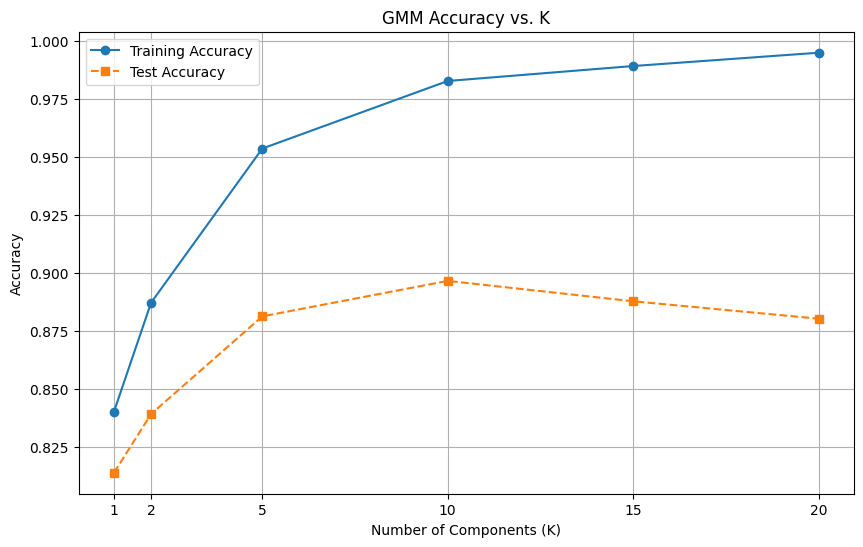

In [12]:
# --- 7. Plot the results ---
print("\nPlotting results...")
plt.figure(figsize=(10, 6))
plt.plot(K_values, train_accuracies, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(K_values, test_accuracies, marker='s', linestyle='--', label='Test Accuracy')
plt.xlabel('Number of Components (K)')
plt.ylabel('Accuracy')
plt.title("GMM Accuracy vs. K")
plt.xticks(K_values)
plt.legend()
plt.grid(True)
plt.savefig("gmm_accuracy_vs_k.jpg", format='jpg')
plt.show()

In [13]:
print(train_accuracies)
print(test_accuracies)

[np.float64(0.8401666666666666), np.float64(0.8871), np.float64(0.95355), np.float64(0.9826666666666667), np.float64(0.9891166666666666), np.float64(0.99485)]
[np.float64(0.8138), np.float64(0.8391), np.float64(0.8812), np.float64(0.8965), np.float64(0.8877), np.float64(0.8802)]


Helper functions defined.
GMM Censored Prediction & Reconstruction functions defined.

Test images censored. 640 pixels observed, 144 pixels missing.

--- Running CENSORED test for K = 1 ---
Censored Test Accuracy (K=1): 66.60%
Censored test for K=1 finished in 5.02s

--- Running CENSORED test for K = 2 ---
Censored Test Accuracy (K=2): 71.02%
Censored test for K=2 finished in 9.92s

--- Running CENSORED test for K = 5 ---
Censored Test Accuracy (K=5): 75.71%
Censored test for K=5 finished in 24.82s

--- Running CENSORED test for K = 10 ---
Censored Test Accuracy (K=10): 78.17%
Censored test for K=10 finished in 49.29s

--- Running CENSORED test for K = 15 ---
Censored Test Accuracy (K=15): 79.01%
Censored test for K=15 finished in 73.25s

--- Running CENSORED test for K = 20 ---
Censored Test Accuracy (K=20): 79.70%
Censored test for K=20 finished in 97.85s

Plotting censored accuracy results...


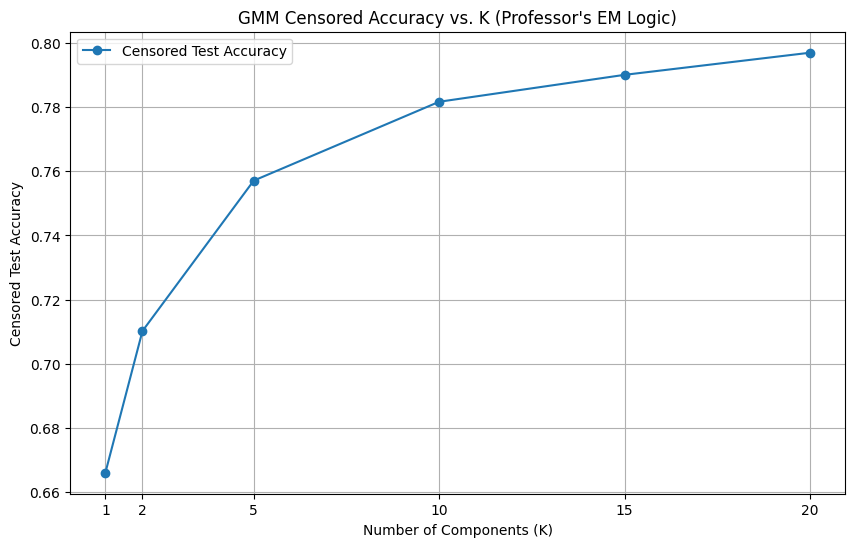


Generating example reconstructions...


C:\Users\OMEN\AppData\Local\Temp\ipykernel_873480\3684992557.py:128: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_resp_unnorm_k[k] = np.log(pivals_c[k] + 1e-30) + \


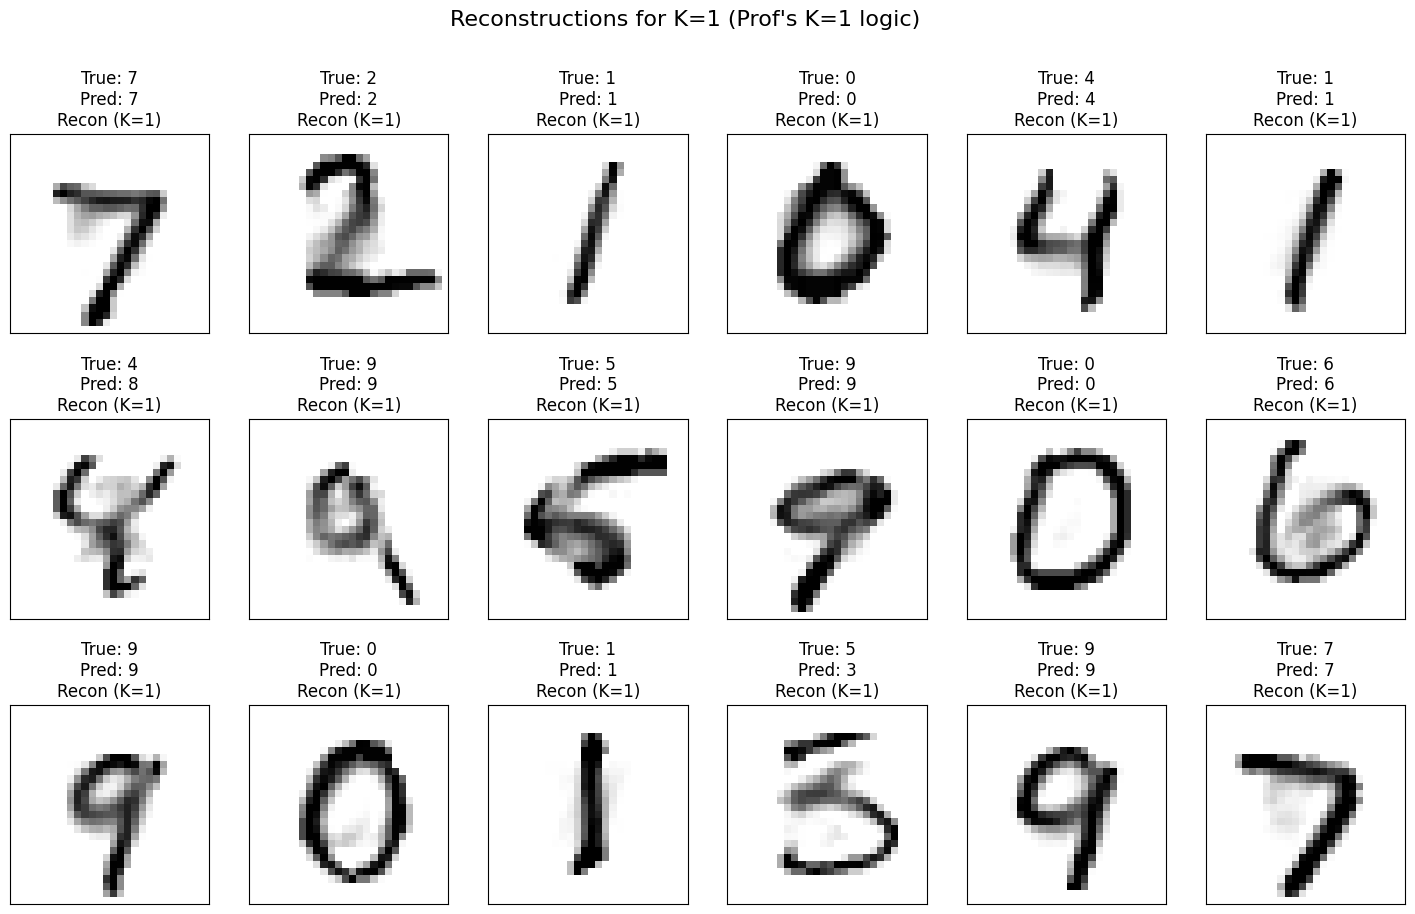

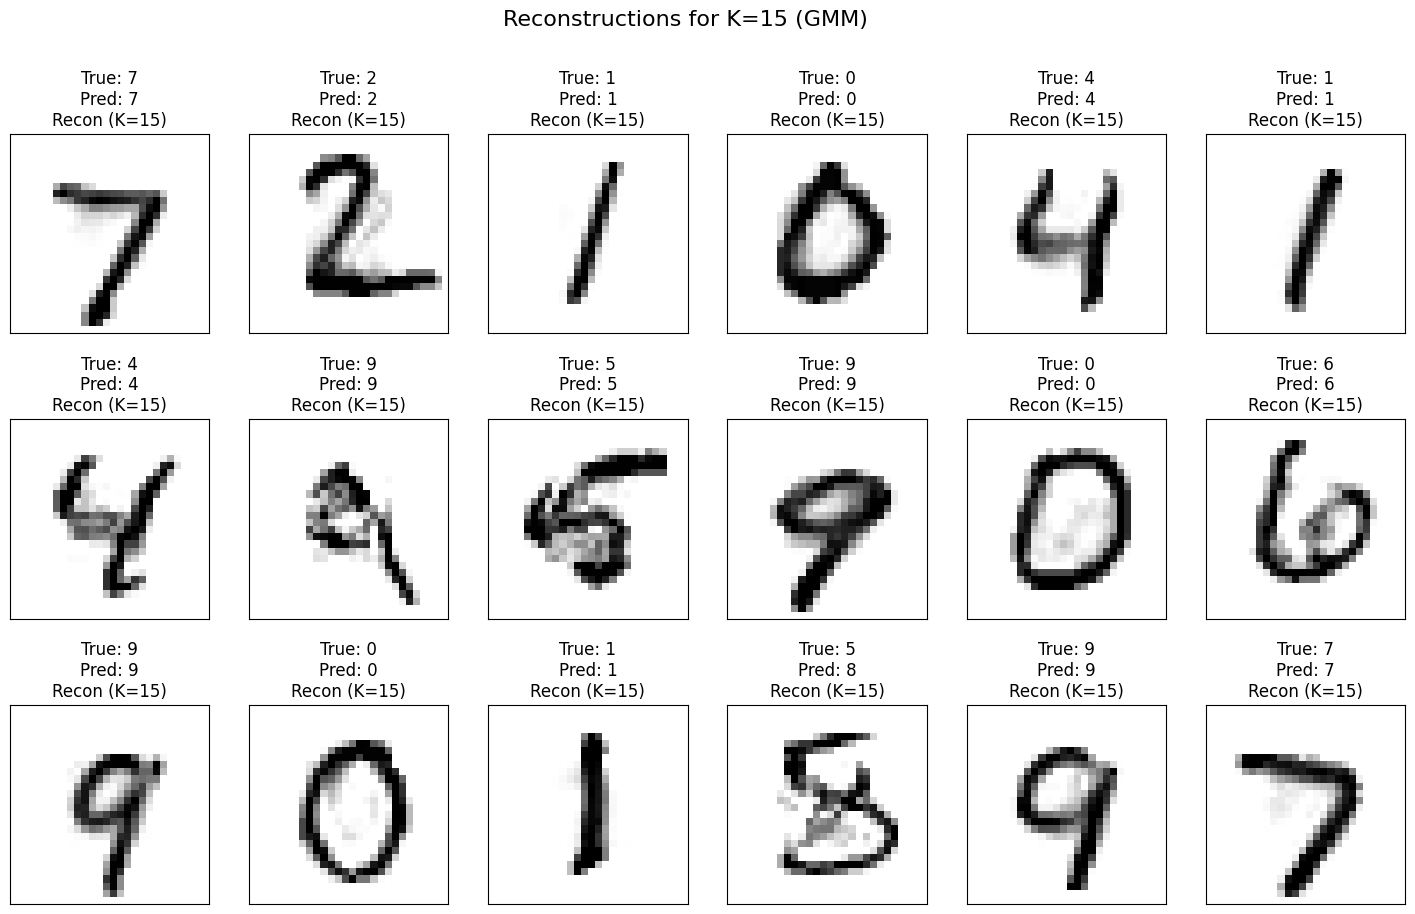

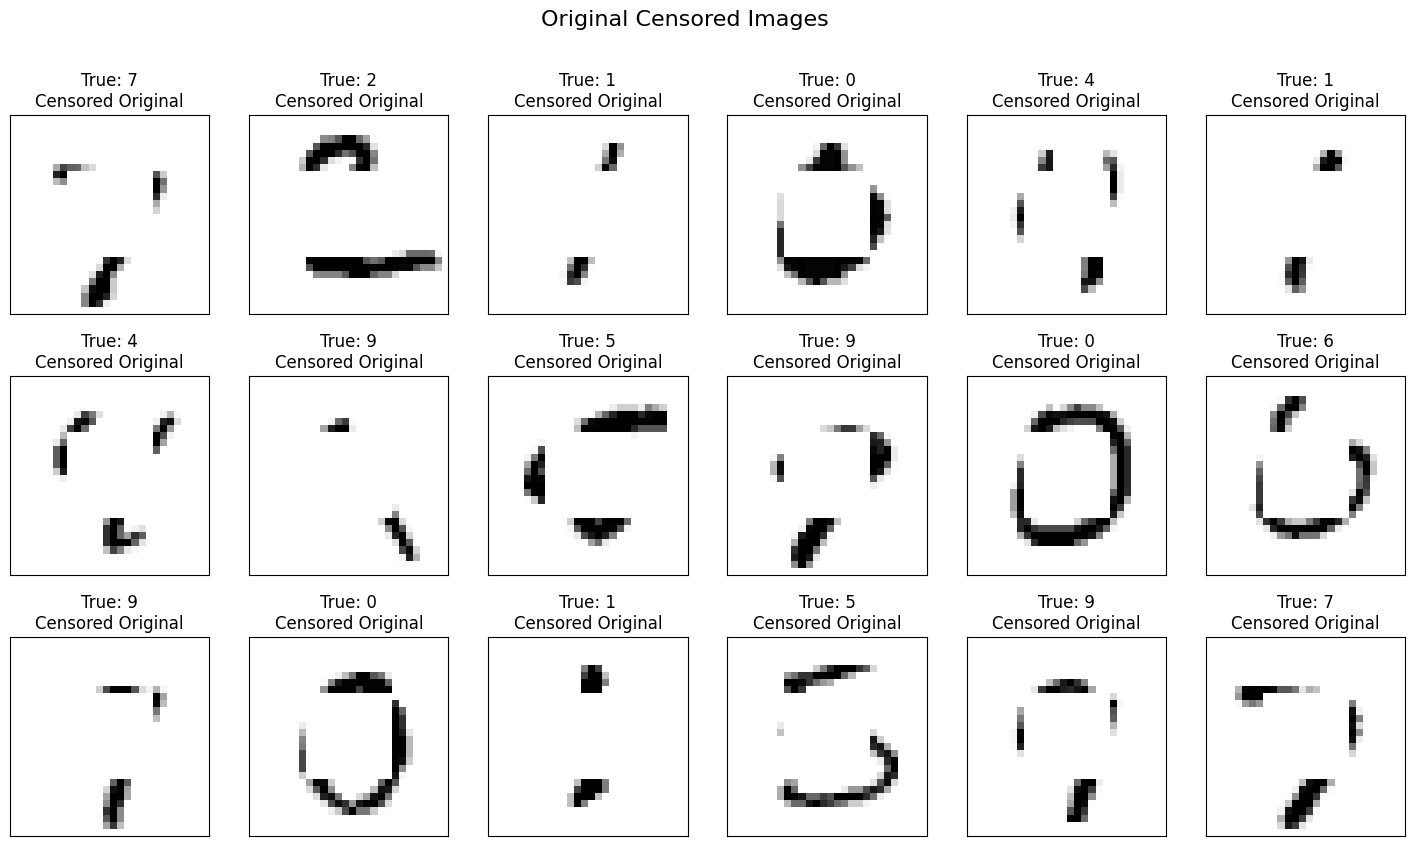

In [11]:
# Import necessary libraries (if this is a new cell)
import numpy as np
from numpy import random as rand
from numpy import linalg as lin
import random
from cs771 import plotData as pd
from cs771 import utils
import matplotlib.pyplot as plt
import time

# --- 1. Define Helper Functions (from notebook & Part 3) ---

# Professor's functions from Cell 21 (UNCHANGED)
def censorImages( X ):
    X_censored = np.array(X) # Make a copy
    X_censored[:, 8:20, 8:20] = 0
    return X_censored

def truncatePixels( X, low = 0, high = 1 ):
    X_trunc = np.array(X)
    X_trunc[X_trunc < low] = low
    X_trunc[X_trunc > high] = high
    return X_trunc

# flattenTensor (from notebook)
def flattenTensor( X ):
    n = X.shape[0]
    d = np.prod( X.shape[1:] )
    return X.reshape( n, d )

# logsumexp helper from Part 3 (UNCHANGED)
def logsumexp(a, axis=1):
    a_max = np.max(a, axis=axis, keepdims=True)
    is_inf = np.isinf(a_max)
    a_max[is_inf] = 0
    tmp = np.exp(a - a_max)
    s = np.sum(tmp, axis=axis, keepdims=True)
    s[is_inf] = 0
    out = a_max + np.log(s + 1e-30) 
    return out.reshape(-1)

# --- 2. New Helper Function (Masked log-prob) ---
# This is based on the professor's `predictClassScores` from Cell 20
# It calculates log N(x_o | mu_o, Sigma_oo) using the mask
def log_prob_component_masked( X, mu, Sigma, mask ):
    XCent = X[:,mask] - mu[mask]
    d_masked = np.sum(mask)
    
    try:
        # Slice Sigma to get Sigma_oo
        Sigma_oo = Sigma[mask,:][:,mask]
        # Add epsilon for stability
        Sigma_stable = Sigma_oo + np.identity(d_masked) * 1e-6
        SInv = lin.pinv( Sigma_stable )
        (sign, logdet) = lin.slogdet( Sigma_stable )
    except lin.LinAlgError:
        return np.full(X.shape[0], -np.inf) 

    if sign <= 0:
        SLogDet = -1e100 # Penalize
    else:
        SLogDet = logdet
        
    # This is term1 from predictClassScores (from Cell 20)
    term1_prof = 0.5 * (-SLogDet - np.sum( np.multiply( np.dot(XCent, SInv), XCent), axis = 1 ))
    return term1_prof

print("Helper functions defined.")

# --- 3. MAJOR CHANGE: New Censored Prediction Function ---
# This replaces `predictGen(..., mask=mask)` from Cell 21
def predictGen_GMM_Censored_Prof(X_test, C, K, gmm_models, mask):
    
    (gmm_mus, gmm_sigmas, gmm_pivals, priors) = gmm_models
    
    n_test = X_test.shape[0]
    classScores = np.zeros((n_test, C))
    component_log_scores = np.zeros((n_test, K))
    
    for c in range(C):
        log_prior_c = np.log(priors[c] + 1e-30) 
        mus_c = gmm_mus[c]
        sigmas_c = gmm_sigmas[c]
        pivals_c = gmm_pivals[c]
        
        for k in range(K):
            # Calculate log N(x_o | mu_k, Sigma_k_oo)
            log_pdf_k = log_prob_component_masked(X_test, mus_c[k], sigmas_c[k], mask)
            
            # component_score = log(pi_k) + log N(x_o | ...)
            component_log_scores[:, k] = np.log(pivals_c[k] + 1e-30) + log_pdf_k
            
        # log P(x_o | y=c) = log( sum_{k} exp(component_log_score_k) )
        log_likelihood = logsumexp(component_log_scores, axis=1)
        
        classScores[:, c] = log_likelihood + log_prior_c
        
    return np.argmax(classScores, axis=1)

# --- 4. MAJOR CHANGE: New GMM Reconstruction Function ---
# This replaces `reconstructImages` from Cell 21
def reconstructImages_GMM_Prof(X_censored, yPred, C, K, gmm_models, mask):
    
    (gmm_mus, gmm_sigmas, gmm_pivals, priors) = gmm_models
    
    XRecon = np.array(X_censored) # Start with the censored image
    
    n_observed = np.sum(mask)
    n_missing = np.sum(~mask)
    
    # Pre-calculate mask indices for slicing
    mask_obs = mask
    mask_mis = ~mask
    
    # Loop over each image
    for i in range(X_censored.shape[0]):
        c = yPred[i] # The predicted class
        x_o = X_censored[i, mask_obs] # Observed pixels
        
        # Get models for this class
        mus_c = gmm_mus[c]       # (K, 784)
        sigmas_c = gmm_sigmas[c]   # (K, 784, 784)
        pivals_c = gmm_pivals[c]   # (K,)
        
        # --- Step A: Calculate Responsibilities (beta_k) ---
        log_resp_unnorm_k = np.zeros(K)
        for k in range(K):
            log_resp_unnorm_k[k] = np.log(pivals_c[k] + 1e-30) + \
                                   log_prob_component_masked(X_censored[i:i+1], mus_c[k], sigmas_c[k], mask_obs)
        
        # responsibilities (beta_k) = exp(log_resp_k - logsumexp(log_resp_k))
        responsibilities = np.exp(log_resp_unnorm_k - logsumexp(log_resp_unnorm_k, axis=0))
        
        # --- Step B: Calculate K Conditional Means ---
        all_recons_k = np.zeros((K, n_missing))
        
        for k in range(K):
            mu_k = mus_c[k]
            sigma_k = sigmas_c[k]
            
            # Partition mu and Sigma using the mask
            mu_m = mu_k[mask_mis]
            mu_o = mu_k[mask_obs]
            
            Sigma_mo = sigma_k[mask_mis, :][:, mask_obs]
            Sigma_oo = sigma_k[mask_obs, :][:, mask_obs]
            
            Sigma_oo_stable = Sigma_oo + np.identity(n_observed) * 1e-6
            Sigma_oo_inv = lin.pinv(Sigma_oo_stable)
            
            # This is the K=1 formula from Cell 21
            recon_k = mu_m + Sigma_mo.dot(Sigma_oo_inv).dot(x_o - mu_o)
            all_recons_k[k, :] = recon_k

        # --- Step C: Calculate Weighted Average ---
        # x_m_final = sum_{k} [beta_k * x_m_k]
        x_m_final = responsibilities.dot(all_recons_k)
        
        # --- Step D: Fill in the image ---
        XRecon[i, mask_mis] = x_m_final
            
    return truncatePixels(XRecon) # Use truncatePixels from Cell 21

print("GMM Censored Prediction & Reconstruction functions defined.")

# --- 5. Censor Test Data (using variables from data loading cell) ---
XTestCensor = censorImages( XTest / 256.0 ) 
XTestCensorFlat = flattenTensor(XTestCensor)
mask = flattenTensor( censorImages( np.ones(imShape)[np.newaxis, :] ) )[0] == 1
print(f"\nTest images censored. {np.sum(mask)} pixels observed, {np.sum(~mask)} pixels missing.")

# --- 6. Run Censored Experiment and Plot ---
test_accuracies_censored = []
# K_values, C, yTest should exist from Part 3
# gmm_models_all_K_prof (with all trained models) should exist from Part 3

for K in K_values:
    print(f"\n--- Running CENSORED test for K = {K} ---")
    start_time = time.time()
    
    # Get the models we already trained in Part 3
    gmm_models = gmm_models_all_K_prof[K]
    (gmm_mus, gmm_sigmas, gmm_pivals, priors) = gmm_models
    
    # --- Predict on Censored Test Data ---
    #
    # *** THIS IS THE CORRECTED FUNCTION CALL ***
    # We call the new function defined in *this* cell (Step 3)
    yPredTestCensored = predictGen_GMM_Censored_Prof(XTestCensorFlat, C, K, gmm_models, mask)
    
    test_acc_censored = np.sum(yPredTestCensored == yTest) / yTest.size
    test_accuracies_censored.append(test_acc_censored)
    print(f"Censored Test Accuracy (K={K}): {test_acc_censored * 100:.2f}%")
    print(f"Censored test for K={K} finished in {time.time() - start_time:.2f}s")

# --- 7. Plot the Censored Accuracy Curve ---
print("\nPlotting censored accuracy results...")
plt.figure(figsize=(10, 6))
plt.plot(K_values, test_accuracies_censored, marker='o', linestyle='-', label='Censored Test Accuracy')
plt.xlabel('Number of Components (K)')
plt.ylabel('Censored Test Accuracy')
plt.title("GMM Censored Accuracy vs. K (Professor's EM Logic)")
plt.xticks(K_values)
plt.legend()
plt.grid(True)
plt.show()

# --- 8. Show Example Reconstructions ---
# We will just show examples for K=1 and K=15 (as an example)
print("\nGenerating example reconstructions...")
numRows = 3
numCols = 6
n_examples = numRows * numCols

# --- Get models for K=1 and K=15 (as examples) ---
K_example_1 = 1
gmm_models_k1 = gmm_models_all_K_prof[K_example_1]
(gmm_mus_k1, gmm_sigmas_k1, gmm_pivals_k1, priors_k1) = gmm_models_k1

# Find a K_example_2 that exists, e.g., 15 or 20
K_example_2 = 15 if 15 in gmm_models_all_K_prof else K_values[-1]
gmm_models_k_high = gmm_models_all_K_prof[K_example_2]
(gmm_mus_k_high, gmm_sigmas_k_high, gmm_pivals_k_high, priors_k_high) = gmm_models_k_high

# --- Get predictions for these examples ---
yPred_k1 = predictGen_GMM_Censored_Prof(XTestCensorFlat[:n_examples], C, K_example_1, gmm_models_k1, mask)
yPred_k_high = predictGen_GMM_Censored_Prof(XTestCensorFlat[:n_examples], C, K_example_2, gmm_models_k_high, mask)

# --- Reconstruct Images ---
XTestRecon_k1 = reconstructImages_GMM_Prof(XTestCensorFlat[:n_examples], yPred_k1, C, K_example_1, gmm_models_k1, mask)
XTestRecon_k_high = reconstructImages_GMM_Prof(XTestCensorFlat[:n_examples], yPred_k_high, C, K_example_2, gmm_models_k_high, mask)

# --- Plot K=1 Reconstructions (Baseline) ---
fig_k1, axs_k1 = pd.getFigList(numRows, numCols, sizey=3.5)
labels_k1 = [f"True: {yTest[i]}\nPred: {yPred_k1[i]}\nRecon (K=1)" for i in range(n_examples)]
pd.showImagesNoAxes(axs_k1, XTestRecon_k1, numRows, numCols, resize=True, imShape=imShape, labelList=labels_k1)
plt.suptitle(f"Reconstructions for K={K_example_1} (Prof's K=1 logic)", fontsize=16)
plt.show()

# --- Plot K_high Reconstructions (GMM) ---
fig_k_high, axs_k_high = pd.getFigList(numRows, numCols, sizey=3.5)
labels_k_high = [f"True: {yTest[i]}\nPred: {yPred_k_high[i]}\nRecon (K={K_example_2})" for i in range(n_examples)]
pd.showImagesNoAxes(axs_k_high, XTestRecon_k_high, numRows, numCols, resize=True, imShape=imShape, labelList=labels_k_high)
plt.suptitle(f"Reconstructions for K={K_example_2} (GMM)", fontsize=16)
plt.show()

# --- Plot the original censored images for comparison ---
fig_c, axs_c = pd.getFigList(numRows, numCols, sizey=3.2)
labels_c = [f"True: {yTest[i]}\nCensored Original" for i in range(n_examples)]
pd.showImagesNoAxes(axs_c, XTestCensorFlat[:n_examples], numRows, numCols, resize=True, imShape=imShape, labelList=labels_c)
plt.suptitle("Original Censored Images", fontsize=16)
plt.show()


Plotting censored accuracy results...


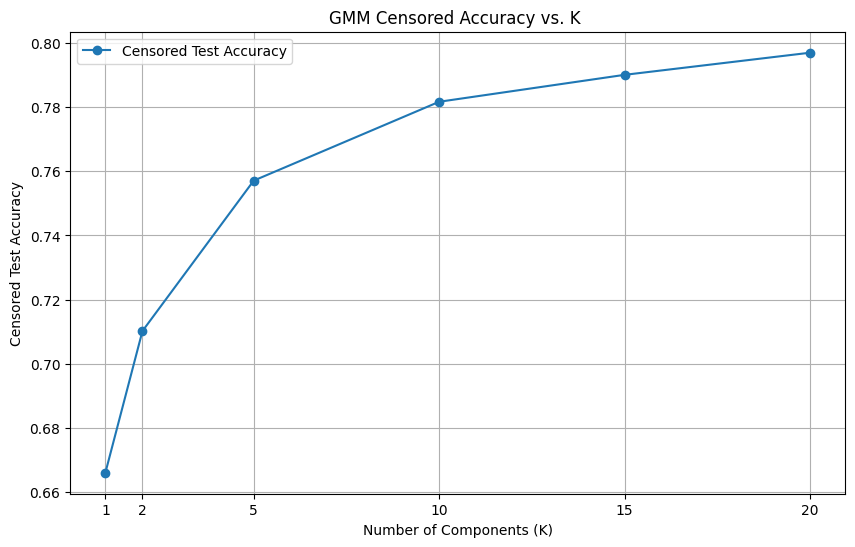

In [14]:
# --- 7. Plot the Censored Accuracy Curve ---
print("\nPlotting censored accuracy results...")
plt.figure(figsize=(10, 6))
plt.plot(K_values, test_accuracies_censored, marker='o', linestyle='-', label='Censored Test Accuracy')
plt.xlabel('Number of Components (K)')
plt.ylabel('Censored Test Accuracy')
plt.title("GMM Censored Accuracy vs. K ")
plt.xticks(K_values)
plt.legend()
plt.grid(True)
plt.savefig("gmm_Censored_accuracy_vs_k.jpg", format='jpg')
plt.show()


Helper functions defined.
GMM Censored Prediction & Reconstruction functions defined.

Test images censored. 640 pixels observed, 144 pixels missing.

--- Running CENSORED test for K = 1 ---
Censored Test Accuracy (K=1): 66.60%
Censored test for K=1 finished in 4.37s

--- Running CENSORED test for K = 2 ---
Censored Test Accuracy (K=2): 71.04%
Censored test for K=2 finished in 8.61s

--- Running CENSORED test for K = 5 ---
Censored Test Accuracy (K=5): 75.92%
Censored test for K=5 finished in 24.50s

--- Running CENSORED test for K = 10 ---
Censored Test Accuracy (K=10): 78.18%
Censored test for K=10 finished in 48.66s

--- Running CENSORED test for K = 15 ---
Censored Test Accuracy (K=15): 79.51%
Censored test for K=15 finished in 73.43s

--- Running CENSORED test for K = 20 ---
Censored Test Accuracy (K=20): 79.87%
Censored test for K=20 finished in 95.32s

Plotting censored accuracy results...
Censored plot saved as gmm_censored_accuracy_vs_k.jpg


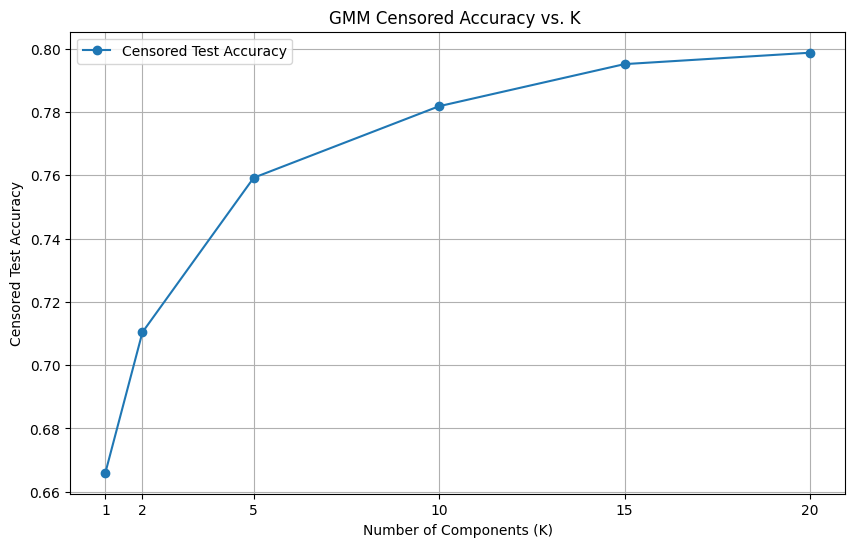


Generating example reconstructions...


C:\Users\OMEN\AppData\Local\Temp\ipykernel_874940\3582927056.py:132: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_resp_unnorm_k[k] = np.log(pivals_c[k] + 1e-30) + \


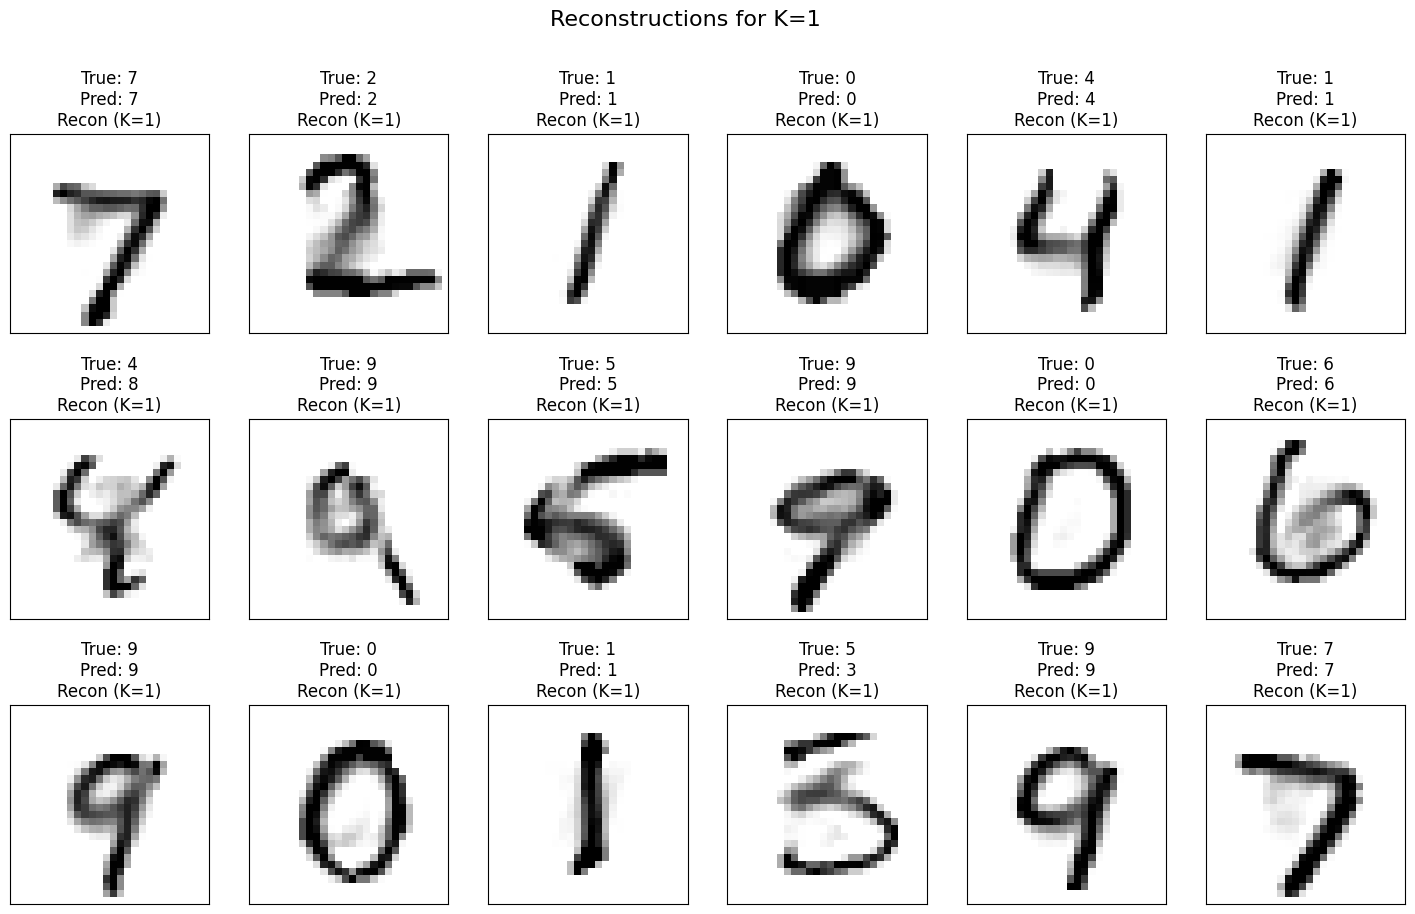

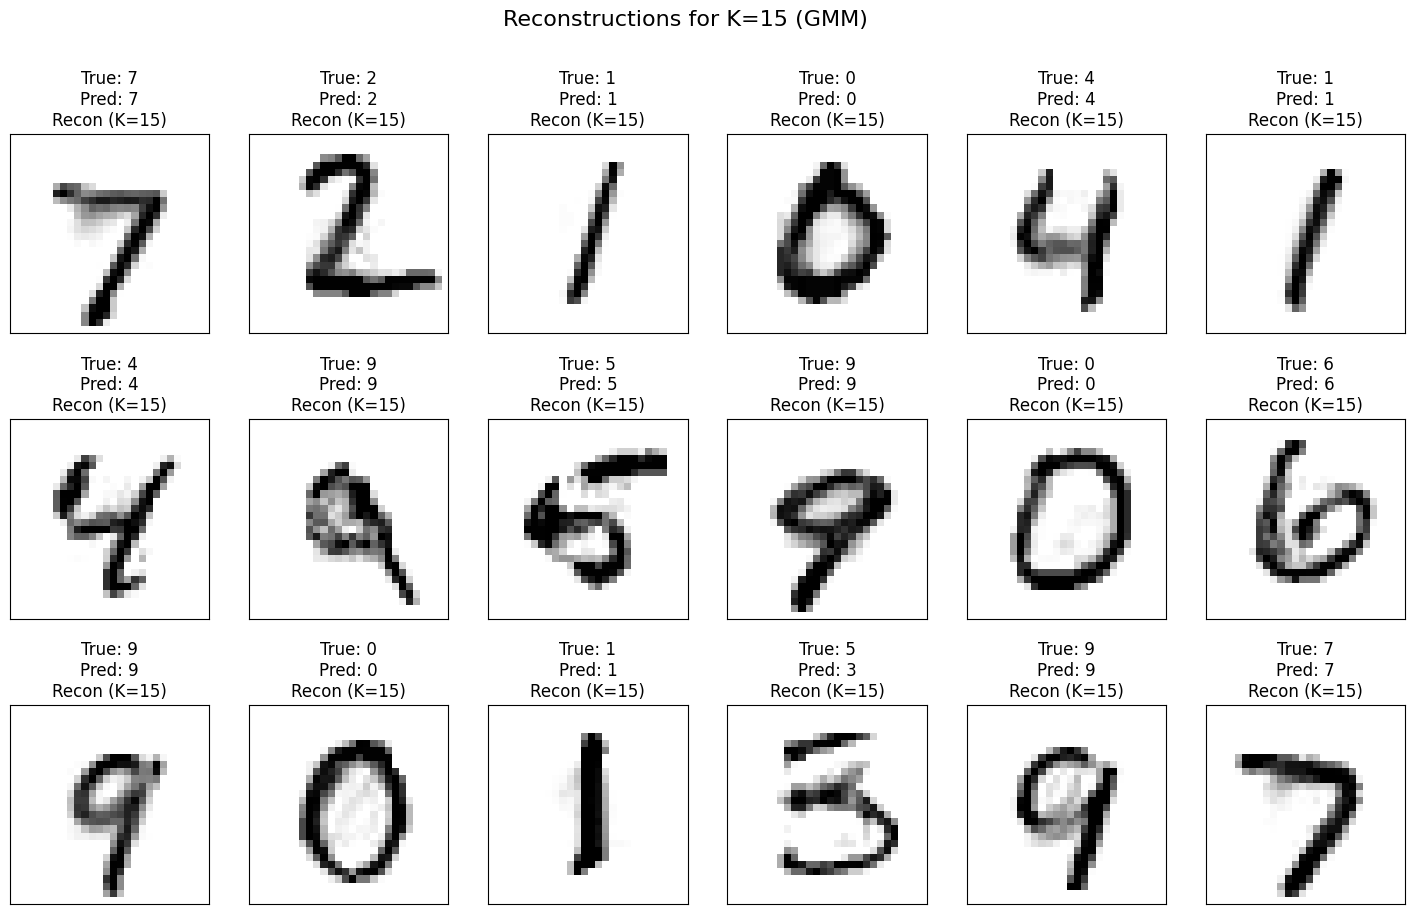

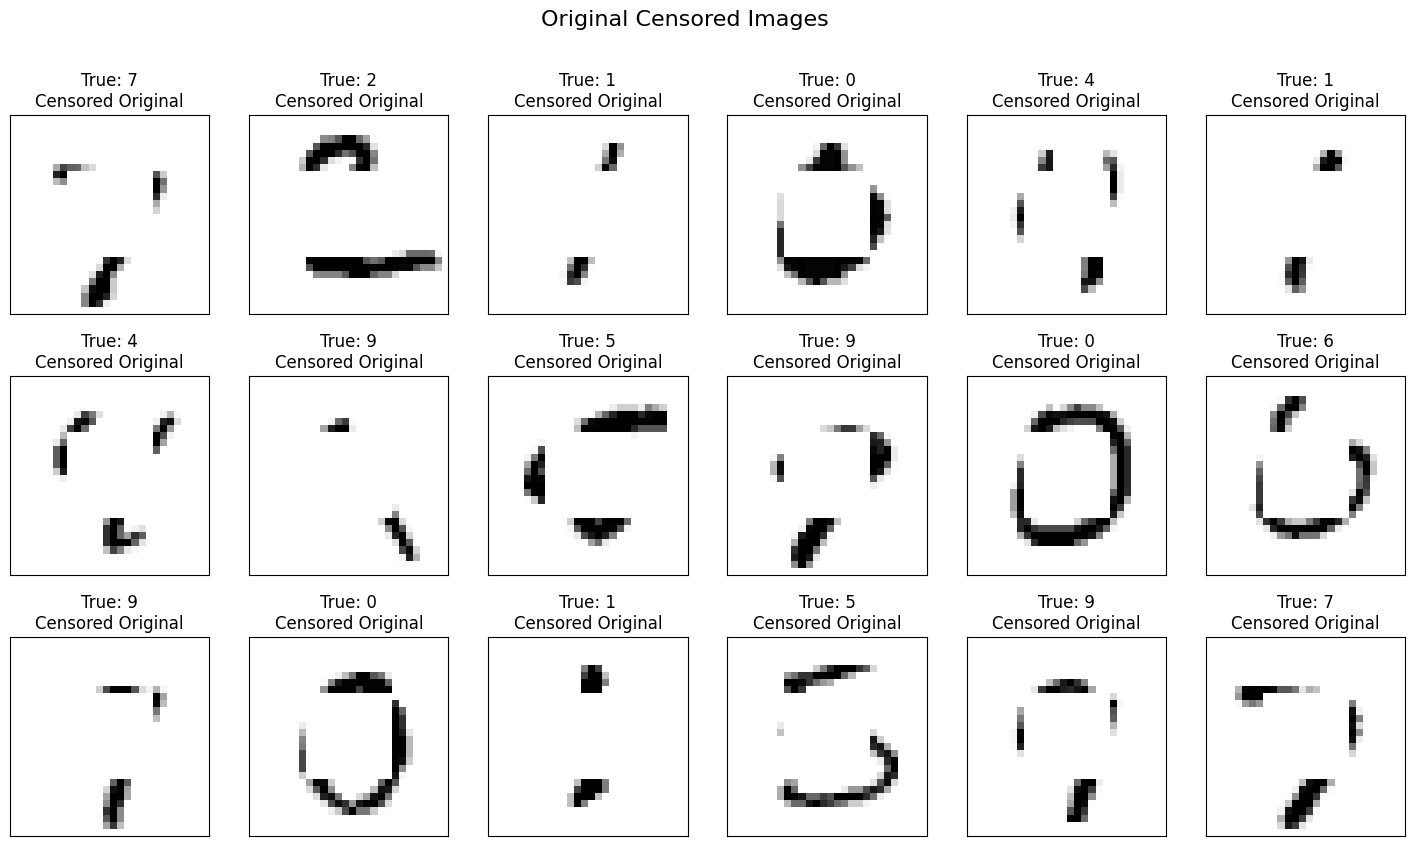

In [14]:
# Import necessary libraries (if this is a new cell)
import numpy as np
from numpy import random as rand
from numpy import linalg as lin
import random
from cs771 import plotData as pd
from cs771 import utils
import matplotlib.pyplot as plt
import time

# --- 1. Define Helper Functions (from notebook & Part 3) ---

# Professor's functions from Cell 21 (UNCHANGED)
def censorImages( X ):
    X_censored = np.array(X) # Make a copy
    # Wipe out 21% of the pixels from the central part of the image
    X_censored[:, 8:20, 8:20] = 0
    return X_censored

def truncatePixels( X, low = 0, high = 1 ):
    X_trunc = np.array(X)
    X_trunc[X_trunc < low] = low
    X_trunc[X_trunc > high] = high
    return X_trunc

# flattenTensor (from notebook)
def flattenTensor( X ):
    n = X.shape[0]
    d = np.prod( X.shape[1:] )
    return X.reshape( n, d )

# logsumexp helper from Part 3 (UNCHANGED)
def logsumexp(a, axis=1):
    a_max = np.max(a, axis=axis, keepdims=True)
    is_inf = np.isinf(a_max)
    a_max[is_inf] = 0
    tmp = np.exp(a - a_max)
    s = np.sum(tmp, axis=axis, keepdims=True)
    s[is_inf] = 0
    out = a_max + np.log(s + 1e-30) 
    return out.reshape(-1)

# --- 2. New Helper Function (Masked log-prob) ---
# This is based on the professor's `predictClassScores` from Cell 20
# It calculates log N(x_o | mu_o, Sigma_oo) using the mask
def log_prob_component_masked( X, mu, Sigma, mask ):
    XCent = X[:,mask] - mu[mask]
    d_masked = np.sum(mask)
    
    try:
        # Slice Sigma to get Sigma_oo
        Sigma_oo = Sigma[mask,:][:,mask]
        # Add epsilon for stability
        Sigma_stable = Sigma_oo + np.identity(d_masked) * 1e-6
        SInv = lin.pinv( Sigma_stable )
        (sign, logdet) = lin.slogdet( Sigma_stable )
    except lin.LinAlgError:
        return np.full(X.shape[0], -np.inf) 

    if sign <= 0:
        SLogDet = -1e100 # Penalize
    else:
        SLogDet = logdet
        
    # This is term1 from predictClassScores (from Cell 20)
    term1_prof = 0.5 * (-SLogDet - np.sum( np.multiply( np.dot(XCent, SInv), XCent), axis = 1 ))
    return term1_prof

print("Helper functions defined.")

# --- 3. MAJOR CHANGE: New Censored Prediction Function ---
# This replaces `predictGen(..., mask=mask)` from Cell 21
def predictGen_GMM_Censored_Prof(X_test, C, K, gmm_models, mask):
    
    (gmm_mus, gmm_sigmas, gmm_pivals, priors) = gmm_models
    
    n_test = X_test.shape[0]
    classScores = np.zeros((n_test, C))
    # We need to store component scores for *each* K component
    component_log_scores = np.zeros((n_test, K)) 
    
    for c in range(C):
        log_prior_c = np.log(priors[c] + 1e-30) 
        mus_c = gmm_mus[c]
        sigmas_c = gmm_sigmas[c]
        pivals_c = gmm_pivals[c]
        
        for k in range(K):
            # Calculate log N(x_o | mu_k, Sigma_k_oo)
            log_pdf_k = log_prob_component_masked(X_test, mus_c[k], sigmas_c[k], mask)
            
            # component_score = log(pi_k) + log N(x_o | ...)
            component_log_scores[:, k] = np.log(pivals_c[k] + 1e-30) + log_pdf_k
            
        # log P(x_o | y=c) = log( sum_{k} exp(component_log_score_k) )
        log_likelihood = logsumexp(component_log_scores, axis=1)
        
        classScores[:, c] = log_likelihood + log_prior_c
        
    return np.argmax(classScores, axis=1)

# --- 4. MAJOR CHANGE: New GMM Reconstruction Function ---
# This replaces `reconstructImages` from Cell 21
def reconstructImages_GMM_Prof(X_censored, yPred, C, K, gmm_models, mask):
    
    (gmm_mus, gmm_sigmas, gmm_pivals, priors) = gmm_models
    
    XRecon = np.array(X_censored) # Start with the censored image
    
    n_observed = np.sum(mask)
    n_missing = np.sum(~mask)
    
    # Pre-calculate mask indices for slicing
    mask_obs = mask
    mask_mis = ~mask
    
    # Loop over each image
    for i in range(X_censored.shape[0]):
        c = yPred[i] # The predicted class
        x_o = X_censored[i, mask_obs] # Observed pixels
        
        # Get models for this class
        mus_c = gmm_mus[c]       # (K, 784)
        sigmas_c = gmm_sigmas[c]   # (K, 784, 784)
        pivals_c = gmm_pivals[c]   # (K,)
        
        # --- Step A: Calculate Responsibilities (beta_k) ---
        # beta_k = P(z=k | x_o, y=c)
        log_resp_unnorm_k = np.zeros(K)
        for k in range(K):
            # log_resp_unnorm_k[k] = log(pi_k) + log N(x_o | mu_k_o, Sigma_k_oo)
            log_resp_unnorm_k[k] = np.log(pivals_c[k] + 1e-30) + \
                                   log_prob_component_masked(X_censored[i:i+1], mus_c[k], sigmas_c[k], mask_obs)
        
        # responsibilities (beta_k) = exp(log_resp_k - logsumexp(log_resp_k))
        responsibilities = np.exp(log_resp_unnorm_k - logsumexp(log_resp_unnorm_k, axis=0))
        
        # --- Step B: Calculate K Conditional Means ---
        # x_m_k = E[x_m | x_o, z=k, y=c]
        all_recons_k = np.zeros((K, n_missing))
        
        for k in range(K):
            mu_k = mus_c[k]
            sigma_k = sigmas_c[k]
            
            # Partition mu and Sigma using the mask
            mu_m = mu_k[mask_mis]
            mu_o = mu_k[mask_obs]
            
            Sigma_mo = sigma_k[mask_mis, :][:, mask_obs]
            Sigma_oo = sigma_k[mask_obs, :][:, mask_obs]
            
            Sigma_oo_stable = Sigma_oo + np.identity(n_observed) * 1e-6
            Sigma_oo_inv = lin.pinv(Sigma_oo_stable)
            
            # This is the K=1 formula from Cell 21
            recon_k = mu_m + Sigma_mo.dot(Sigma_oo_inv).dot(x_o - mu_o)
            all_recons_k[k, :] = recon_k

        # --- Step C: Calculate Weighted Average ---
        # x_m_final = sum_{k} [beta_k * x_m_k]
        x_m_final = responsibilities.dot(all_recons_k)
        
        # --- Step D: Fill in the image ---
        XRecon[i, mask_mis] = x_m_final
            
    return truncatePixels(XRecon) # Use truncatePixels from Cell 21

print("GMM Censored Prediction & Reconstruction functions defined.")

# --- 5. Censor Test Data (using variables from data loading cell) ---
# We assume XTest, yTest, and imShape are already loaded
XTestCensor = censorImages( XTest / 256.0 ) 
XTestCensorFlat = flattenTensor(XTestCensor)
mask = flattenTensor( censorImages( np.ones(imShape)[np.newaxis, :] ) )[0] == 1
print(f"\nTest images censored. {np.sum(mask)} pixels observed, {np.sum(~mask)} pixels missing.")

# --- 6. Run Censored Experiment and Plot ---
test_accuracies_censored = []
# K_values, C, yTest should exist from Part 3
# gmm_models_all_K_prof (with all trained models) should exist from Part 3

for K in K_values:
    print(f"\n--- Running CENSORED test for K = {K} ---")
    start_time = time.time()
    
    # Get the models we already trained in Part 3
    gmm_models = gmm_models_all_K_prof[K]
    
    # --- Predict on Censored Test Data ---
    yPredTestCensored = predictGen_GMM_Censored_Prof(XTestCensorFlat, C, K, gmm_models, mask)
    
    test_acc_censored = np.sum(yPredTestCensored == yTest) / yTest.size
    test_accuracies_censored.append(test_acc_censored)
    print(f"Censored Test Accuracy (K={K}): {test_acc_censored * 100:.2f}%")
    print(f"Censored test for K={K} finished in {time.time() - start_time:.2f}s")

# --- 7. Plot the Censored Accuracy Curve ---
print("\nPlotting censored accuracy results...")
plt.figure(figsize=(10, 6))
plt.plot(K_values, test_accuracies_censored, marker='o', linestyle='-', label='Censored Test Accuracy')
plt.xlabel('Number of Components (K)')
plt.ylabel('Censored Test Accuracy')
plt.title("GMM Censored Accuracy vs. K ")
plt.xticks(K_values)
plt.legend()
plt.grid(True)

# Save the censored accuracy plot
plt.savefig("gmm_censored_accuracy_vs_k.jpg", format='jpg')
print("Censored plot saved as gmm_censored_accuracy_vs_k.jpg")

plt.show()

# --- 8. Show Example Reconstructions ---
# We will show examples for K=1 and K=15 (as an example)
print("\nGenerating example reconstructions...")
numRows = 3
numCols = 6
n_examples = numRows * numCols

# --- Get models for K=1 and K=15 (as examples) ---
K_example_1 = 1
gmm_models_k1 = gmm_models_all_K_prof[K_example_1]

# Find a K_example_2 that exists, e.g., 15 or 20
K_example_2 = 15 if 15 in K_values else K_values[-1]
gmm_models_k_high = gmm_models_all_K_prof[K_example_2]

# --- Get predictions for these examples ---
yPred_k1 = predictGen_GMM_Censored_Prof(XTestCensorFlat[:n_examples], C, K_example_1, gmm_models_k1, mask)
yPred_k_high = predictGen_GMM_Censored_Prof(XTestCensorFlat[:n_examples], C, K_example_2, gmm_models_k_high, mask)

# --- Reconstruct Images ---
XTestRecon_k1 = reconstructImages_GMM_Prof(XTestCensorFlat[:n_examples], yPred_k1, C, K_example_1, gmm_models_k1, mask)
XTestRecon_k_high = reconstructImages_GMM_Prof(XTestCensorFlat[:n_examples], yPred_k_high, C, K_example_2, gmm_models_k_high, mask)

# # --- Plot K=1 Reconstructions (Baseline) ---
# fig_k1, axs_k1 = pd.getFigList(numRows, numCols, sizey=3.5)
# labels_k1 = [f"True: {yTest[i]}\nPred: {yPred_k1[i]}\nRecon (K=1)" for i in range(n_examples)]
# pd.showImagesNoAxes(axs_k1, XTestRecon_k1, numRows, numCols, resize=True, imShape=imShape, labelList=labels_k1)
# plt.suptitle(f"Reconstructions for K={K_example_1}", fontsize=16)
# plt.savefig("reconstructions_K1.jpg", format='jpg')
# plt.show()

# # --- Plot K_high Reconstructions (GMM) ---
# fig_k_high, axs_k_high = pd.getFigList(numRows, numCols, sizey=3.5)
# labels_k_high = [f"True: {yTest[i]}\nPred: {yPred_k_high[i]}\nRecon (K={K_example_2})" for i in range(n_examples)]
# pd.showImagesNoAxes(axs_k_high, XTestRecon_k_high, numRows, numCols, resize=True, imShape=imShape, labelList=labels_k_high)
# plt.suptitle(f"Reconstructions for K={K_example_2} (GMM)", fontsize=16)
# plt.savefig(f"reconstructions_K{K_example_2}.jpg", format='jpg')
# plt.show()

# # --- Plot the original censored images for comparison ---
# fig_c, axs_c = pd.getFigList(numRows, numCols, sizey=3.2)
# labels_c = [f"True: {yTest[i]}\nCensored Original" for i in range(n_examples)]
# pd.showImagesNoAxes(axs_c, XTestCensorFlat[:n_examples], numRows, numCols, resize=True, imShape=imShape, labelList=labels_c)
# plt.suptitle("Original Censored Images", fontsize=16)
# plt.savefig("censored_originals.jpg", format='jpg', dpi=300)
# plt.show()


Plotting censored accuracy results...
Censored plot saved as gmm_censored_accuracy_vs_k.jpg


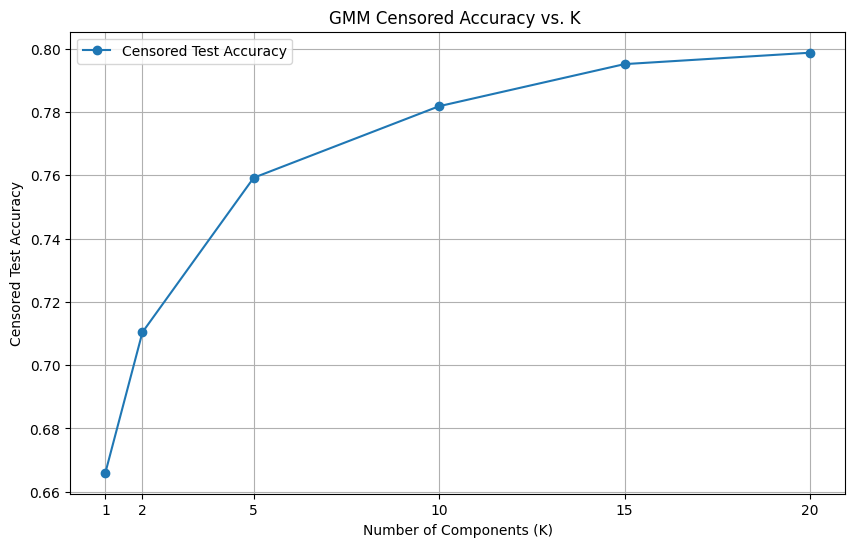

In [15]:
print("\nPlotting censored accuracy results...")
plt.figure(figsize=(10, 6))
plt.plot(K_values, test_accuracies_censored, marker='o', linestyle='-', label='Censored Test Accuracy')
plt.xlabel('Number of Components (K)')
plt.ylabel('Censored Test Accuracy')
plt.title("GMM Censored Accuracy vs. K ")
plt.xticks(K_values)
plt.legend()
plt.grid(True)

# Save the censored accuracy plot
plt.savefig("gmm_censored_accuracy_vs_k.jpg", format='jpg')
print("Censored plot saved as gmm_censored_accuracy_vs_k.jpg")

plt.show()